# Исследовательский анализ данных

## Загрузка и и импотры библиотек

Прежде всего установим недостающие библиотеки для проекта

In [1]:
!pip install catboost -q

In [2]:
!pip install psycopg2-binary -q

In [3]:
!pip install SQLAlchemy==1.4.22 -q














































































































































































Загрузим библиотеки проекта в алфавитном порядке согласно PEP-8

In [4]:
import catboost
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pkg_resources
import psycopg2
from scipy.stats import randint
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sqlalchemy import create_engine, text
import torch
from tqdm import trange
import warnings

RANDOM_STATE = 250723


np.random.seed(RANDOM_STATE)
pd.set_option('display.max_colwidth', None)
torch.random.manual_seed(RANDOM_STATE)
warnings.filterwarnings("ignore")

## Подключение к базе данных SQL


In [5]:
db_config = {
'user': '...',# имя пользователя
'pwd': '...',# пароль
'host': '...',
'port': ...,# порт подключения
'db': '...'# название базы данных,
}

Создаем подключение к базе данных:

In [6]:
connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)
engine = create_engine(connection_string)

## Функции проекта

Все функции, используемые в течение проекта будут находиться в данном разделе:

In [7]:
def download_data(table_name):

    """
    Функция загружает данные из базы данных SQL в формате Pandas DataFrame.

    Параметры:
        table_name (str): Имя таблицы, из которой требуется загрузить данные.

    Возвращаемое значение:
        pandas.DataFrame: DataFrame, содержащий загруженные данные.
    """

    query = f'SELECT * FROM steel.{table_name};'
    data = pd.read_sql_query(query, con=engine)
    return data

In [8]:
def show_data(table_name):

    """
    Функция загружает и выводит первые 5 строк данных из базы данных SQL в формате Pandas DataFrame.

    Параметры:
        table_name (str): Имя таблицы, из которой требуется загрузить данные.

    Возвращаемое значение:
        None
    """

    query = f'SELECT * FROM steel.{table_name} LIMIT 5;'
    data = pd.read_sql_query(query, con=engine)
    display(data)

In [9]:
def columns_data(table_name):

    """
    Функция возвращает список названий столбцов из базы данных SQL для указанной таблицы.

    Параметры:
        table_name (str): Имя таблицы, для которой требуется получить названия столбцов.

    Возвращаемое значение:
        list: Список, содержащий названия столбцов таблицы.
    """

    query = f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}';"

    columns_data = pd.read_sql_query(query, con=engine)
    return columns_data['column_name'].tolist()

In [10]:
def count_null_values(table_name):

    """
    Функция возвращает количество пропущенных значений (null) для каждого столбца указанной таблицы.

    Параметры:
        table_name (str): Имя таблицы, для которой требуется посчитать количество пропущенных значений.

    Возвращаемое значение:
        pandas.DataFrame: DataFrame, содержащий количество пропущенных значений для каждого столбца.
    """

    columns = columns_data(table_name)
    column_expr = ', '.join([f'COUNT(*) - COUNT("{col}") AS "{col}"' for col in columns])
    query = f"SELECT {column_expr} FROM steel.{table_name};"
    null_counts = pd.read_sql_query(query, con=engine)
    null_counts.index = ['Количество пропусков в столбце']
    return null_counts

In [11]:
def data_entries_len(table_name):

    """
    Функция выводит количество записей (объектов) в указанной таблице.

    Параметры:
        table_name (str): Имя таблицы, для которой требуется получить количество записей.

    Возвращаемое значение:
        None, на экран выводится строка с информацией о количестве объектов в DataFrame
    """

    query = f'SELECT COUNT(*) FROM steel.{table_name}'
    data = pd.read_sql_query(query, con=engine)
    print(f'Таблица {table_name} имеет {data.iloc[0][0]} объектов')

In [12]:
def get_statistics_for_column(table_name, column):

    """
    Функция возвращает статистические метрики для указанного столбца в таблице.

    Параметры:
        table_name (str): Имя таблицы, в которой содержится указанный столбец.
        column (str): Имя столбца, для которого требуется получить статистические метрики.

    Возвращаемое значение:
        dict: Словарь с ключами, содержащими статистические метрики (min_value, max_value, mean_value, std_value,
              q1_value, median_value, q3_value) и их соответствующими значениями.
    """

    connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)
    engine = create_engine(connection_string)

    sql_query = text(f'''
        SELECT
            ROUND(MIN("{column}"), 3) AS min_value,
            ROUND(MAX("{column}"), 3) AS max_value,
            ROUND(AVG("{column}"), 3) AS mean_value,
            ROUND(STDDEV("{column}"), 3) AS std_value,
            ROUND(PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY "{column}")::numeric, 3) AS q1_value,
            ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY "{column}")::numeric, 3) AS median_value,
            ROUND(PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY "{column}")::numeric, 3) AS q3_value
        FROM steel."{table_name}"
    ''')

    with engine.connect() as conn:
        result = conn.execute(sql_query).fetchone()

    return dict(result)


In [13]:
def table_statistics(table_name, columns):

    """
    Функция возвращает DataFrame состоящий из статистическиx метрик для указанных столбцов в переданной таблице.

    Параметры:
        table_name (str): Имя таблицы, в которой содержатся указанные столбцы.
        columns (list): Список имен столбцов, для которых требуется получить статистические метрики.

    Возвращаемое значение:
        pandas.DataFrame: DataFrame, содержащий статистические метрики для каждого указанного столбца.
            Индекс DataFrame будет содержать имена столбцов, столбцы соответствуют различным статистическим метрикам.
    """

    statistics = {}
    for column in columns:
        statistics[column] = get_statistics_for_column(table_name, column)

    df = pd.DataFrame.from_dict(statistics, orient='index')
    return df

In [14]:
def print_data_types_decorator(func):

    """
    Декоратор для функций, возвращающих информацию о типах данных столбцов в таблице.

    Параметры:
        func (function): Функция, которая возвращает структуру данных с информацией о типах данных столбцов.

    Возвращаемое значение:
        function: Обернутая функция-обертка (wrapper), которая выводит информацию о типах данных столбцов на экран.
    """

    def wrapper(table_name):
        column_data_types = func(table_name)
        df = pd.DataFrame(column_data_types, columns=['Имя столбца', 'Тип данных'])
        display(df)

    return wrapper

In [15]:
@print_data_types_decorator
def get_column_data_types(table_name):

    """
    Функция возвращает информацию о типах данных столбцов для указанной таблицы.

    Параметры:
        table_name (str): Имя таблицы, для которой требуется получить информацию о типах данных столбцов.

    Возвращаемое значение:
        list: Список кортежей, содержащих информацию о типах данных столбцов.
            Каждый кортеж имеет два элемента: имя столбца и его тип данных.
    """

    connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)
    engine = create_engine(connection_string)

    sql_query = text(f'''
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_name = '{table_name}';
    ''')

    with engine.connect() as conn:
        result = conn.execute(sql_query).fetchall()

    return result

In [16]:
def time_to_seconds(time_str):

    """
    Функция преобразует строку времени в формате "часы:минуты:секунды" в число секунд.

    Параметры:
        time_str (str): Строка времени в формате "часы:минуты:секунды".

    Возвращаемое значение:
        int or float or None: Значение времени в секундах. Если входная строка равна None, то возвращается None.
    """

    if time_str is None or pd.isnull(time_str):
        return None
    hours, minutes, seconds = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60 + seconds


def time_to_seconds_2(time_str):
    if time_str is None or pd.isnull(time_str):
        return None
    hours = time_str.hour
    minutes = time_str.minute
    seconds = time_str.second
    return hours * 3600 + minutes * 60 + seconds


In [17]:
def plot_distribution(data, column, title=None):

    """
    Функция строит гистограмму распределения данных для указанного столбца в датафрейме.

    Параметры:
        data (pandas.DataFrame): Датафрейм, содержащий данные.
        column (str): Имя столбца, для которого требуется построить гистограмму распределения.
        title (str, по умолчанию None): Название графика. Если не указано, используется автоматически сформированное название.

    Возвращаемое значение:
        None
        Выводит на экран графики для каждого столбца.
    """

    plt.figure()
    sns.histplot(data[column].dropna(), kde=True)
    plt.title(f"Распределение столбца '{column}'" if title is None else title)
    plt.xlabel(column)
    plt.ylabel("Частота")
    plt.show()

In [18]:
def filter_rows_with_data(data_frame, column_to_exclude):

    """
    Функция фильтрует строки в датафрейме, исключая те, у которых все значения в указанном столбце равны нулю или None.

    Параметры:
        data_frame (pandas.DataFrame): Датафрейм, который требуется отфильтровать.
        column_to_exclude (str): Имя столбца, значения которого требуется исключить из проверки.

    Возвращаемое значение:
        pandas.DataFrame: Отфильтрованный датафрейм, в котором исключены строки с нулевыми или None значениями в указанном столбце.
    """

    columns_to_sum = data_frame.columns.drop(column_to_exclude)
    mask = (data_frame[columns_to_sum].sum(axis=1) > 0) | data_frame[columns_to_sum].notnull().all(axis=1)
    data_frame_filtered = data_frame[mask] # Фильтрация данных с помощью маски
    return data_frame_filtered

In [19]:
def calculate_total_values(data_frame, key_column, value_columns):

    """
    Рассчитывает суммарные значения указанных столбцов для каждого уникального значения в столбце 'key'.

    Параметры:
        data_frame (DataFrame): Исходный DataFrame, содержащий данные.
        key_column (str): Имя столбца, по которому будет производиться группировка данных.
        value_columns (list): Список имен столбцов, для которых необходимо рассчитать суммарные значения.

    Возвращает:
        DataFrame: DataFrame с рассчитанными суммарными значениями для каждого уникального значения в столбце 'key'.
                  В новых столбцах добавляется префикс 'total_', за которым следует имя соответствующего столбца из value_columns.
    """

    total_values_per_key = data_frame.groupby(key_column)[value_columns].sum()
    total_values_df = pd.DataFrame({key_column: total_values_per_key.index})
    for col in value_columns:
        total_values_df[f'total_{col}'] = total_values_per_key[col].values
    return total_values_df

## Предобработка и анализ данных

В данном разделе будет произведен исследовательский анализ таблиц и их предобработка.

Перед загрузкой таблиц изучим их используя SQL-фильтрацию, чтобы узнать размер файла перед полной выгрузкой и оценить насколько возможна такая выгрузка.

### Таблица data_arc

Таблица **`steel.data_arc` содержит информацию об электродах**

#### Первичное исследование data_arc

In [20]:
show_data('data_arc')

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


В таблице `data_arc` присутствуют десятичные значения мощности. Можно предположить, что это мощности измеряются в киловаттах (кВт).

Пероые строки таблицы выглядят нормально.

In [21]:
get_column_data_types('data_arc')

,Имя столбца,Тип данных
0,key,integer
1,BeginHeat,time without time zone
2,EndHeat,time without time zone
3,ActivePower,numeric
4,ReactivePower,numeric


В базе данных тип данных `time without time zone` может быть представлен в определенном формате, отличном от формата, который Pandas использует для представления времени. Это может привести к тому, что Pandas не распознает тип данных как время и просто интерпретирует его как обычную строку.

In [22]:
count_null_values('data_arc')

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
Количество пропусков в столбце,0,0,0,0,0


Пропусков в таблице нет

In [23]:
data_entries_len('data_arc')

Таблица data_arc имеет 14876 объектов


Размер таблицы позволяет выгрузить ее полностью.

In [24]:
data_arc = download_data('data_arc')

In [25]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Таблица содержит 5 столбцов и 14876 строк типов `int64`, `float64` и  `object`.

#### Предобработка и анализ data_arc

Для удобства переведем наименования столбцов из CamelCase в snake_case:

In [26]:
data_arc = data_arc.rename(columns={"BeginHeat": "begin_heat", "EndHeat": "end_heat", "ActivePower": "active_power", "ReactivePower": "reactive_power"})

In [27]:
for column in ['begin_heat', 'end_heat']:
    data_arc[column] = pd.to_datetime(data_arc[column], format='%H:%M:%S').dt.time

In [28]:
data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


In [29]:
data_entries_len('data_arc')

Таблица data_arc имеет 14876 объектов


Таблица `data_arc` содержит 5 столбцов и 14876 строк.

Изучение наличия аномальных значний в таблице:

In [30]:
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Изучим странные значения в столбце `reactive_power`. При среднем значении в районе 0.4 и среднеквадратичном отклонении  в  5.9 значений минимальное значение выглдит странным. Изучим все значения меньше либо равные нулю

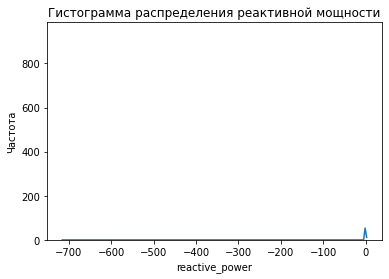

In [31]:
plot_distribution(data_arc, 'reactive_power', title='Гистограмма распределения реактивной мощности')

График отображает ненормальное распределение, где наблюдатся значения меньше нуля, чего быть не должно. Изучим выбросы:

In [32]:
display(data_arc.query('reactive_power <= 0'))

,key,begin_heat,end_heat,active_power,reactive_power
9781,2116,00:44:48,00:46:37,0.495782,-715.504924


Данное значение похоже на ошибку, что может вызвано сбоем приборов либо человеческим фактором при занесении данных в базу данных. Информация о мощности ниже нуля является ошибочной. Данный объект необходимо удалить.

In [33]:
data_arc = data_arc.query('reactive_power > 0')

Выброс удален из таблицы, данные распределены нормально

Данные отфильтрованы, отрицательные значения реактивной можности устранены.
Изучим новое распределение данных реактивной мощности:

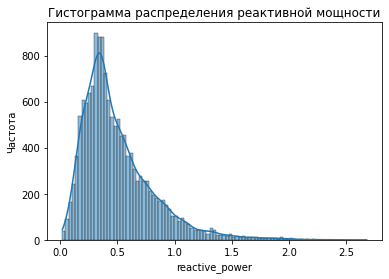

In [34]:
plot_distribution(data_arc, 'reactive_power', title='Гистограмма распределения реактивной мощности')

Распределение похоже на левонаправленное. Это может быть связано с ограничениями по реактивной мощности. В некоторых системах есть ограничения по реактивной мощности, например, в электроэнергетике. Это может привести к скошенности данных влево, так как реактивная мощность ограничена сверху и может принимать значения только в определенном диапазоне.


Далее обработаем столбцы с датой и временем. Абсолютные данные по дате и времени не несут явной пользы в качестве признаков, поэтому необходимо их перевести из строкового в численный тип, переведя в секунды (от начала суток), и вычислить относительные временные признаки, такие как продолжительность нагрева.

In [35]:
# Преобразование времени начала и окончания нагрева в тип datetime
data_arc['begin_heat_datetime'] = pd.to_datetime('1900-01-01 ' + data_arc['begin_heat'].astype(str))
data_arc['end_heat_datetime'] = pd.to_datetime('1900-01-01 ' + data_arc['end_heat'].astype(str))
# Вычисление продолжительности нагрева в секундах
data_arc['heat_duration_in_seconds'] = (data_arc['end_heat_datetime'] - data_arc['begin_heat_datetime']).dt.total_seconds()
# Лямбда-функция для обработки отрицательных значений
add_24_hours = lambda x: x + 24 * 3600 if x < 0 else x
data_arc['heat_duration_in_seconds'] = data_arc['heat_duration_in_seconds'].apply(add_24_hours)
#Преобразование исходных столбцов со временем в секунды (от начала суток)
data_arc['begin_heat_sec'] = data_arc['begin_heat'].apply(lambda x: time_to_seconds(x.strftime('%H:%M:%S')))
data_arc['end_heat_sec'] = data_arc['end_heat'].apply(lambda x: time_to_seconds(x.strftime('%H:%M:%S')))
# Удаление временных и ненужных столбцов
data_arc.drop(['begin_heat_datetime', 'end_heat_datetime', 'begin_heat', 'end_heat'], axis=1, inplace=True)


In [36]:
data_arc.head()

,key,active_power,reactive_power,heat_duration_in_seconds,begin_heat_sec,end_heat_sec
0,1,0.976059,0.687084,228.0,39734,39962
1,1,0.805607,0.520285,185.0,40048,40233
2,1,0.744363,0.498805,172.0,40304,40476
3,1,1.659363,1.062669,365.0,40694,41059
4,1,0.692755,0.414397,148.0,41169,41317


Изучение распределений остальных столбцов:

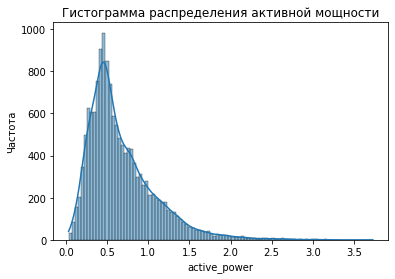

In [37]:
plot_distribution(data_arc, 'active_power', title='Гистограмма распределения активной мощности')

Активная мощность также левоскошенная, что также может быть связана с ограничениями сверху

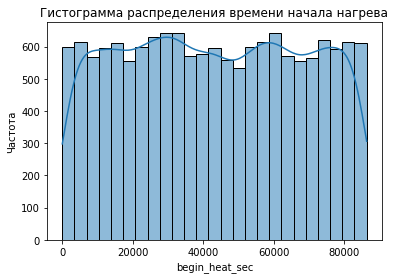

In [38]:
plot_distribution(data_arc, 'begin_heat_sec', title='Гистограмма распределения времени начала нагрева')

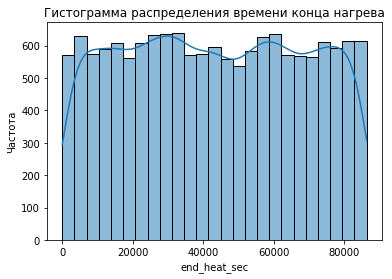

In [39]:
plot_distribution(data_arc, 'end_heat_sec', title='Гистограмма распределения времени конца нагрева')

 Распределение равномерное, скорее всего нагревы были равномерно распределены во времени, без каких-либо явных временных тенденций. Также возможно время начала и конца нагрева почти не зависит от других факторов или переменных, которые могли бы влиять на эти признаки.

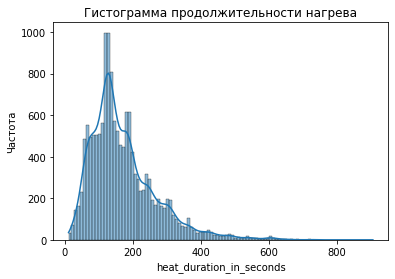

In [40]:
plot_distribution(data_arc, 'heat_duration_in_seconds', title='Гистограмма продолжительности нагрева')

Левонаправленное распределение может быть результатом ограниченных временных интервалов, в течение которых нагревы происходили. Например, это может быть связано с определенными рабочими сменами или периодами активности производства, когда нагревы производились чаще или реже.

**Генерация дополнительных признаков:**

In [41]:
data_arc['general_power'] = np.sqrt(data_arc['active_power'] ** 2 + data_arc['reactive_power'] ** 2) # Суммарная мощность каждого нагрева
data_arc['general_energy'] = data_arc['general_power'] * data_arc['heat_duration_in_seconds'] # Суммарная энергия каждого нагрева

total_power_df = calculate_total_values(data_arc, 'key', ['active_power', 'reactive_power'])
total_energy_df = calculate_total_values(data_arc, 'key', ['general_energy'])
total_heat_df = calculate_total_values(data_arc, 'key', ['heat_duration_in_seconds'])

# Объединяем данные о суммарных значениях с исходной таблицей data_arc
data_arc = data_arc.merge(total_power_df, on='key')
data_arc = data_arc.merge(total_energy_df, on='key')
data_arc = data_arc.merge(total_heat_df, on='key')

data_arc['total_ratio_active_reactive'] = data_arc['total_active_power'] / data_arc['total_reactive_power']

data_arc.rename(columns = {'total_heat_duration_in_seconds': 'heat_duration_in_seconds', 'total_general_energy': 'total_energy'})

# Удаляем ненужные столбцы, оставив только общие значения для каждой партии
data_arc.drop(['active_power', 'reactive_power', 'heat_duration_in_seconds'], axis=1, inplace=True)


In [42]:
data_arc.head()

,key,begin_heat_sec,end_heat_sec,general_power,general_energy,total_active_power,total_reactive_power,total_general_energy,total_heat_duration_in_seconds,total_ratio_active_reactive
0,1,39734,39962,1.193639,272.149755,4.878147,3.183241,1442.377754,1098.0,1.532447
1,1,40048,40233,0.959010,177.416785,4.878147,3.183241,1442.377754,1098.0,1.532447
2,1,40304,40476,0.896038,154.118502,4.878147,3.183241,1442.377754,1098.0,1.532447
3,1,40694,41059,1.970470,719.221394,4.878147,3.183241,1442.377754,1098.0,1.532447
4,1,41169,41317,0.807239,119.471318,4.878147,3.183241,1442.377754,1098.0,1.532447


Изучение распределений новых признаков:

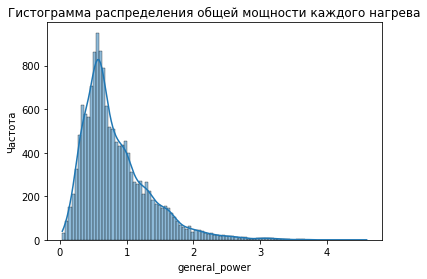

In [43]:
plot_distribution(data_arc, 'general_power', title='Гистограмма распределения общей мощности каждого нагрева')

Общая мощность также имеет левонаправленное распределение, как сумма активной и реактивной мощности

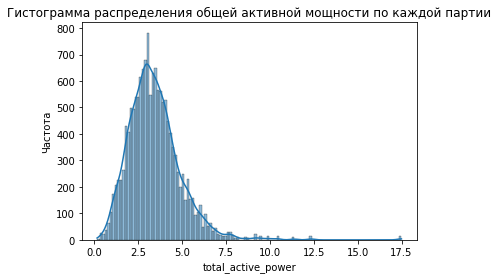

In [44]:
plot_distribution(data_arc, 'total_active_power', title='Гистограмма распределения общей активной мощности по каждой партии')

Данное распределение уже больше похоже на нормальное. При суммировании значений активной мощности для каждой партии возможно сглаживание выбросов, которые могли быть присутствующими в отдельных значениях активной мощности.

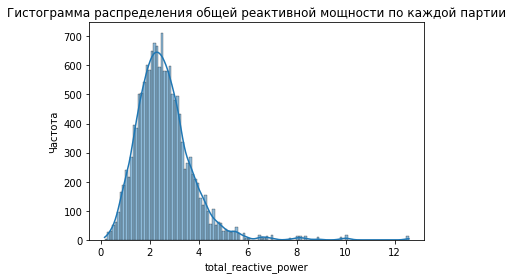

In [45]:
plot_distribution(data_arc, 'total_reactive_power', title='Гистограмма распределения общей реактивной мощности по каждой партии')

Аналогичная картина наблюдается для реактивной мощности

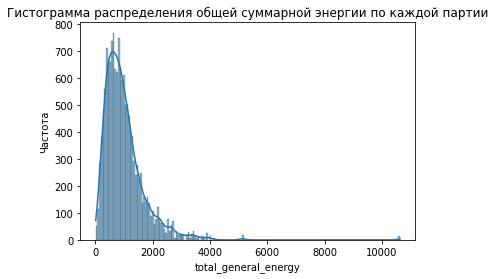

In [46]:
plot_distribution(data_arc, 'total_general_energy', title='Гистограмма распределения общей суммарной энергии по каждой партии')

Гистограмма распределения общей суммарной энергии по каждой партии скошена влево. Это означает, что большинство значений общей суммарной энергии находятся на меньших значениях, а хвост распределения тянется в сторону больших значений.

Это может быть интересной особенностью данных и может указывать на неравномерное распределение энергии между различными партиями. Возможно, есть группы партий с низкими значениями общей суммарной энергии, которые обладают схожими характеристиками процесса нагрева, и есть отдельные партии с высокими значениями общей суммарной энергии, которые могут отличаться по каким-то особенностям.

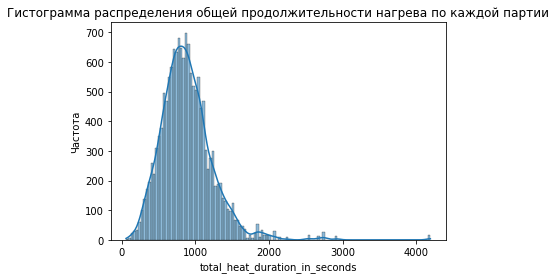

In [47]:
plot_distribution(data_arc, 'total_heat_duration_in_seconds', title='Гистограмма распределения общей продолжительности нагрева по каждой партии')


Гистограмма представляет нормальное распределение. Данное распределение имеет хвост, который тянется вправо и содержит относительно небольшое количество значений с длительностью нагрева, превышающей среднее значение.

Такой хвост справа может быть связан с тем, что иногда возникают длительные нагревы, которые редко, но все же встречаются. Это может быть вызвано различными факторами, такими как аномалии в производственных процессах, изменения условий или другие внешние факторы.

**Вывод:**  данные таблицы data_arc загружены, изучены и предобработаны для дальнейшей работы. Аномальные значения исключены, созданы новые признаки, которые будут использоваться для обучения моделей.

### Таблица data_bulk

Таблица **`data_bulk` хранит данные об объёме сыпучих материалов**

#### Первичное исследование data_bulk

In [48]:
show_data('data_bulk')
data_entries_len('data_bulk')
count_null_values('data_bulk')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,None,None,None,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,None,None,None,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,None,None,None,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,None,None,None,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


Таблица data_bulk имеет 3129 объектов


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
Количество пропусков в столбце,0,2877,3107,1831,2115,3052,2553,3104,3128,3110,2953,2952,679,3111,323,881


In [49]:
data_bulk = download_data('data_bulk')

In [50]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Наша таблица содержит 16 столбцов с типами данных `int64` и `float64`.

Таблица содержит данные о сыпучих смесях. Во многих ячейках имеются пропуски, которые свидетельствуют о том, что данная смесь не добавлялась в данный момент времени. Пропуски необходимо будет заполнить.

#### Предобработка и анализ data_bulk

Переименование столбцов в snake_case:

In [51]:
data_bulk = data_bulk.rename(columns={'Bulk 1': 'bulk_1', 'Bulk 2': 'bulk_2', 'Bulk 3': 'bulk_3', 'Bulk 4': 'bulk_4', 'Bulk 5': 'bulk_5', 'Bulk 6': 'bulk_6',
       'Bulk 7': 'bulk_7', 'Bulk 8': 'bulk_8', 'Bulk 9': 'bulk_9', 'Bulk 10': 'bulk_10', 'Bulk 11': 'bulk_11', 'Bulk 12': 'bulk_12',
       'Bulk 13': 'bulk_13', 'Bulk 14': 'bulk_14', 'Bulk 15': 'bulk_15'})

In [52]:
table_statistics('data_bulk', columns_data('data_bulk'))

,min_value,max_value,mean_value,std_value,q1_value,median_value,q3_value
key,1.000,3241.000,1624.384,933.338,816.000,1622.000,2431.000
Bulk 1,10.000,185.000,39.242,18.278,27.000,31.000,46.000
Bulk 2,228.000,325.000,253.045,21.181,242.000,251.500,257.750
Bulk 3,6.000,454.000,113.879,75.483,58.000,97.500,152.000
Bulk 4,12.000,281.000,104.394,48.184,72.000,102.000,133.000
Bulk 5,11.000,603.000,107.026,81.791,70.000,86.000,132.000
Bulk 6,17.000,503.000,118.925,72.058,69.750,100.000,157.000
Bulk 7,47.000,772.000,305.600,191.023,155.000,298.000,406.000
Bulk 8,49.000,49.000,49.000,None,49.000,49.000,49.000
Bulk 9,63.000,147.000,76.316,21.721,66.000,68.000,70.500


- В столбце "Bulk 8" минимальное, максимальное, среднее и медианное значение совпадают и равны 49.0. Возможно, это какая-то константа или ошибка в данных.
- В столбце "Bulk 12" максимальное значение достаточно большое (1849), и стандартное отклонение (260) тоже заметно выше среднего значения (181). Это может указывать на наличие выбросов или необычных значений.

Полная загрузка таблицы:

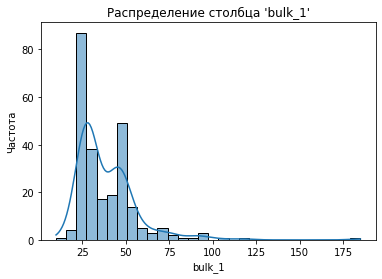

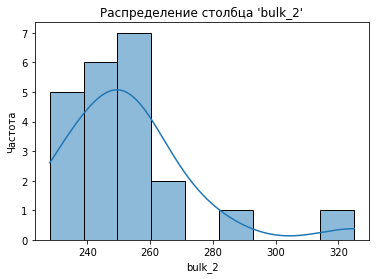

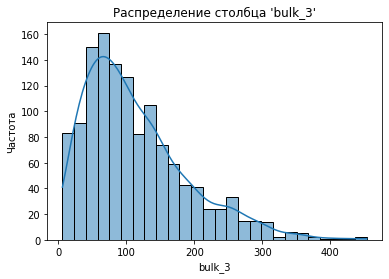

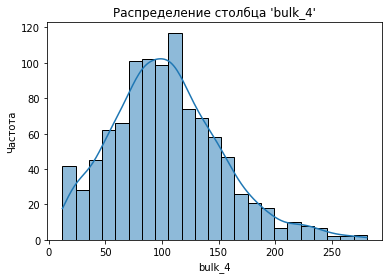

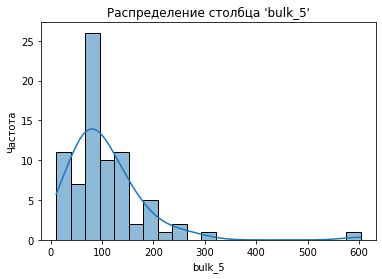

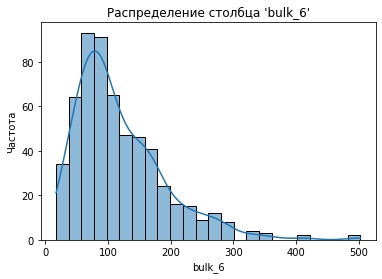

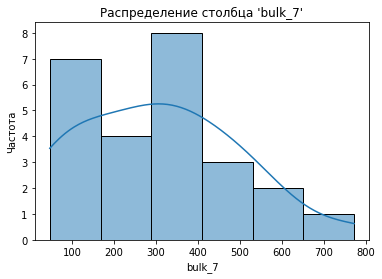

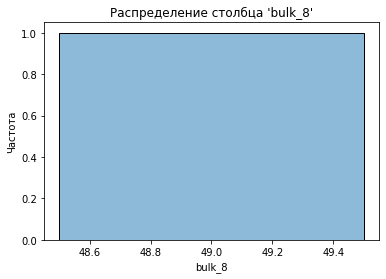

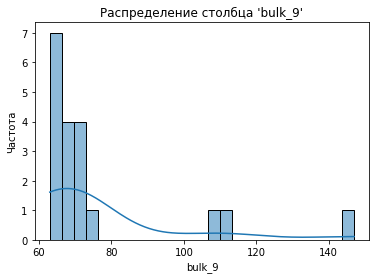

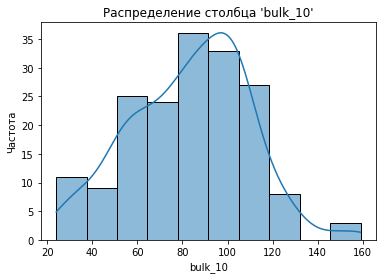

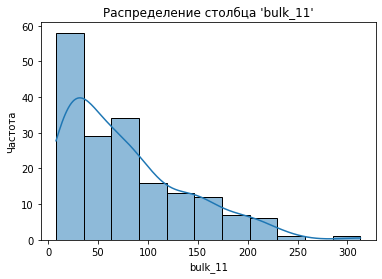

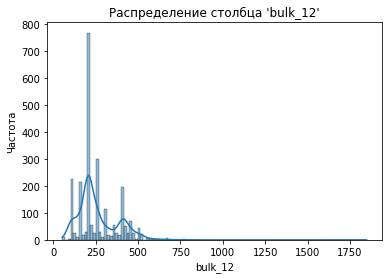

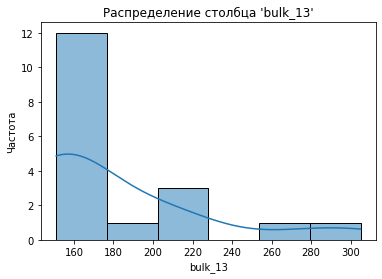

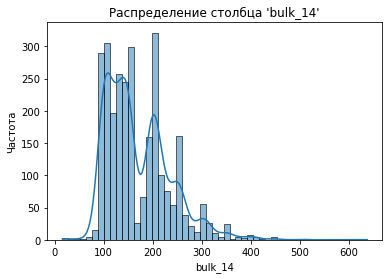

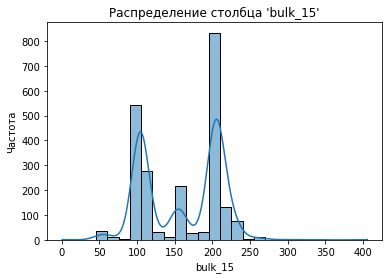

In [53]:
for col in data_bulk.columns:
  if col == 'key':
    continue
  plot_distribution(data_bulk,
                    col)

На графиках никаких особых отклонений не обнаружено, распределение не везде нормальное, что может быть связано с малой или неравномерной подачей материалов.

In [54]:
data_bulk['bulk_8'].value_counts()

49.0    1
Name: bulk_8, dtype: int64

в столбце `Bulk 8` имеется только одно ненулевое значение.

Исследование материала Bulk 12:

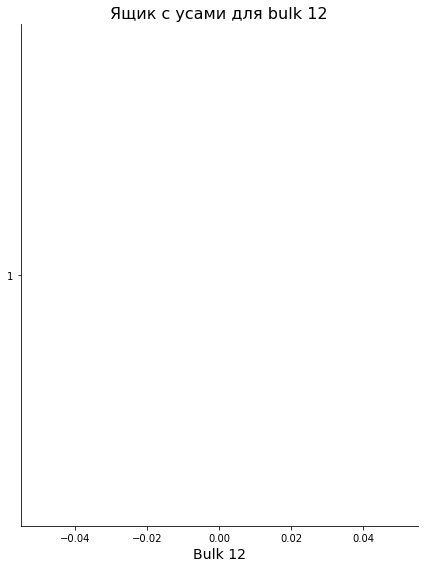

In [55]:
# Создаем график и оси
fig, ax = plt.subplots(figsize=(6, 8))

# Построение ящика с усами
box = ax.boxplot(data_bulk['bulk_12'], vert=False, patch_artist=True)

# Настройки цветов и стилей элементов ящика
box_colors = ['#1f77b4']
box['boxes'][0].set(facecolor=box_colors[0], alpha=0.7)
box['whiskers'][0].set(color='gray', linestyle='--', linewidth=1.5)
box['whiskers'][1].set(color='gray', linestyle='--', linewidth=1.5)
box['caps'][0].set(color='black', linewidth=1.5)
box['caps'][1].set(color='black', linewidth=1.5)
box['medians'][0].set(color='red', linewidth=2)

# Настройки осей и заголовка
ax.set_xlabel('Bulk 12', fontsize=14)
ax.set_title('Ящик с усами для bulk 12', fontsize=16)

# Убираем рамку у графика
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Отображаем график
plt.tight_layout()
plt.show()

Данный материал используется в довольно больших объемах, но имеются выбросы. Исследуем редкие значения:

In [56]:
display(data_bulk.query('`bulk_12` > 1000'))

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


Сложно сказать, является ли подобное значение ошибочным или нет без дополнительной информации, но с учетом того что среднее значение тоже достаточно большое и выше чем для других смесей, исключать данный объект не будем

Заполним пропуски нулями, свидетельстующими о нулевом объеме сыпучих материалов, когда материал в партию не добавляли:

In [57]:
data_bulk = data_bulk.fillna(0)

In [58]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [59]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Пропуски заполнены.

**Вывод:** Данные таблицы data_bulk загружены, изучены и предобработаны для дальнейшей работы. Пропуски обработаны и изучены потенциальные аномалии.

### Таблица data_bulk_time

Таблица **`data_bulk_time` содержит данные о времени подачи сыпучих материалов**

#### Первичное исследование data_bulk_time

In [60]:
show_data('data_bulk_time ')
data_entries_len('data_bulk_time')
count_null_values('data_bulk_time')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


Таблица data_bulk_time имеет 3129 объектов


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
Количество пропусков в столбце,0,2877,3107,1831,2115,3052,2553,3104,3128,3110,2953,2952,679,3111,323,881


#### Предобработка и анализ data_bulk_time

In [61]:
data_bulk_time = download_data('data_bulk_time ')

In [62]:
data_bulk_time = data_bulk_time.rename(columns={'Bulk 1': 'bulk_1', 'Bulk 2': 'bulk_2', 'Bulk 3': 'bulk_3', 'Bulk 4': 'bulk_4', 'Bulk 5': 'bulk_5', 'Bulk 6': 'bulk_6',
       'Bulk 7': 'bulk_7', 'Bulk 8': 'bulk_8', 'Bulk 9': 'bulk_9', 'Bulk 10': 'bulk_10', 'Bulk 11': 'bulk_11', 'Bulk 12': 'bulk_12',
       'Bulk 13': 'bulk_13', 'Bulk 14': 'bulk_14', 'Bulk 15': 'bulk_15'})

In [63]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


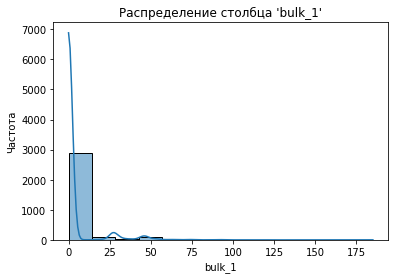

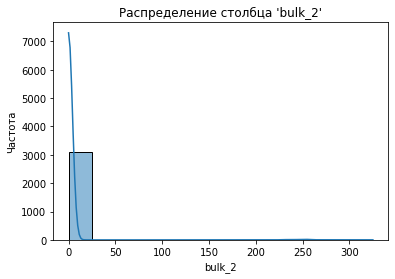

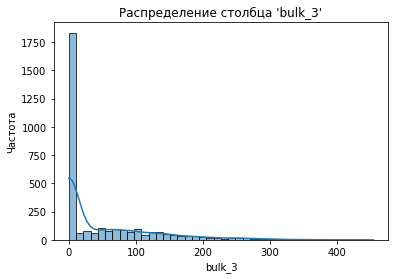

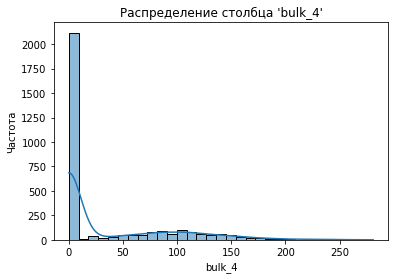

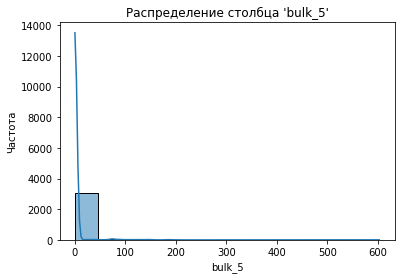

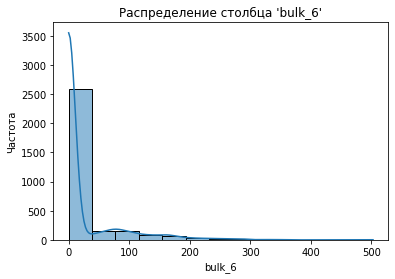

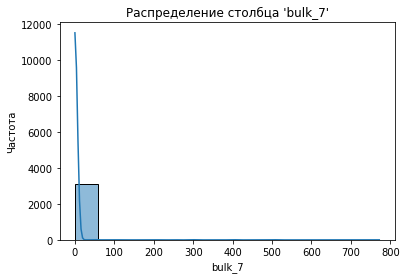

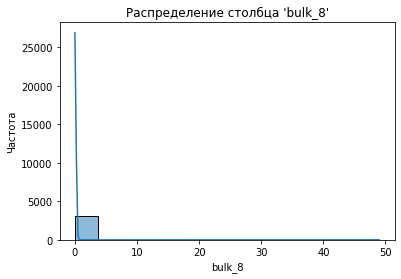

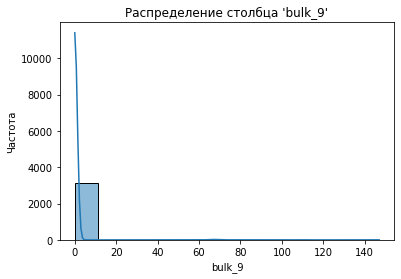

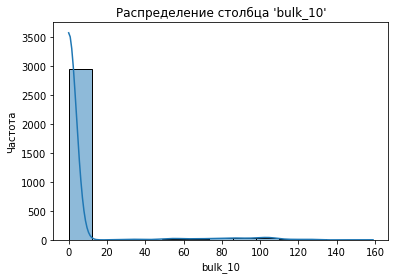

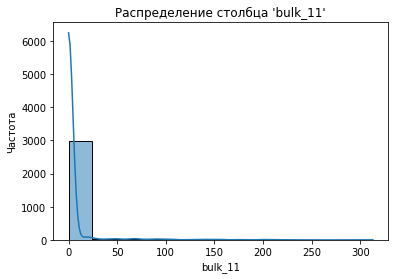

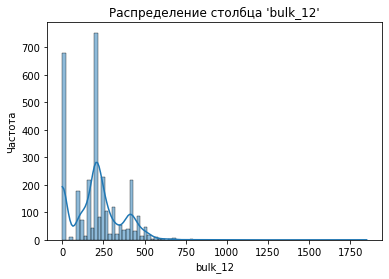

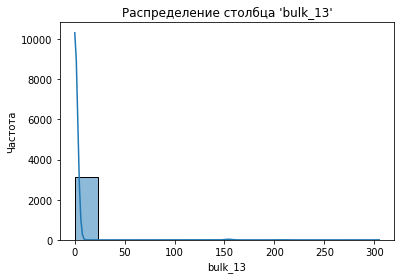

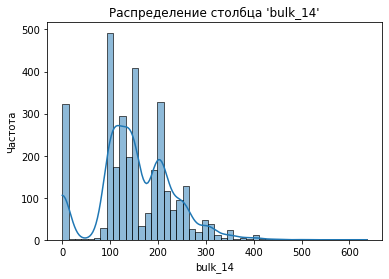

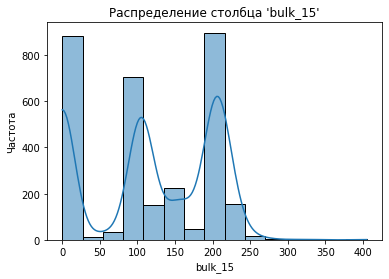

In [64]:
for col in data_bulk_time.columns:
    if col == 'key':
        continue
    plot_distribution(data_bulk, col)

Распределения данного датасета также имеют различную природу из-за малого количества данных и особенностей времени подачи материала.

In [65]:
# Заменяем значения в исходном датасете на секунды
for col in data_bulk_time.columns[1:]:
    data_bulk_time[col] = data_bulk_time[col].apply(time_to_seconds_2)

data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,40890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39832.0,NaN,39832.0,39832.0
1,2,NaN,NaN,NaN,42398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42020.0,NaN,42020.0,42020.0
2,3,NaN,NaN,NaN,45066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43780.0,NaN,43780.0,43780.0
3,4,NaN,NaN,NaN,46123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45684.0,NaN,45684.0,45684.0
4,5,NaN,NaN,NaN,47930.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47576.0,NaN,47576.0,47576.0


In [66]:
data_bulk_time.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,45831.746032,46757.272727,43949.822804,40960.462525,41242.389610,43950.003472,39905.040000,63971.0,30507.368421,40771.465909,44919.192090,42310.439592,50406.722222,42624.291875,42014.434609
std,933.337642,23020.503525,11585.371224,24805.005912,24659.858787,26658.390938,25345.768281,14118.697029,NaN,24064.491668,23321.214749,24075.961031,25125.733658,27306.315875,25078.684065,25187.678411
min,1.000000,13.000000,30979.000000,1.000000,38.000000,93.000000,85.000000,2558.000000,63971.0,296.000000,61.000000,1709.000000,60.000000,2375.000000,11.000000,60.000000
25%,816.000000,29101.000000,36845.000000,23182.750000,19594.000000,16072.000000,21692.000000,31588.000000,63971.0,9443.500000,22999.500000,23670.000000,20252.500000,30889.750000,20831.000000,20046.500000
50%,1622.000000,47709.000000,42723.000000,43148.000000,38613.000000,40138.000000,43845.000000,40220.000000,63971.0,18906.000000,39071.000000,43044.000000,41802.000000,61091.000000,41915.000000,40932.000000
75%,2431.000000,62292.750000,56616.500000,65734.500000,61450.750000,64910.000000,67060.000000,50753.000000,63971.0,51228.500000,59397.500000,65269.000000,64166.250000,73097.000000,64492.250000,64271.750000
max,3241.000000,86064.000000,64910.000000,86252.000000,86370.000000,85354.000000,86175.000000,64910.000000,63971.0,68281.000000,84770.000000,86175.000000,86334.000000,84845.000000,86334.000000,86334.000000


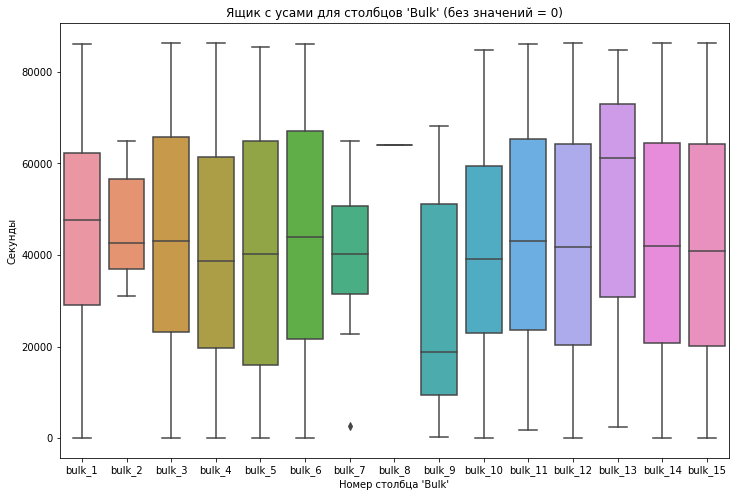

In [67]:
# Построение графика "ящик с усами"
plt.figure(figsize=(12, 8))  # Размер графика
sns.boxplot(data=data_bulk_time.iloc[:, 1:])  # Игнорируем столбец "key"
plt.title("Ящик с усами для столбцов 'Bulk' (без значений = 0)")  # Заголовок графика
plt.xlabel("Номер столбца 'Bulk'")  # Название оси X
plt.ylabel("Секунды")  # Название оси Y
plt.show()  # Показать график

**Проверка адекватности данных**

Подача материала не должна измеряться сутками - это означает, что время подачи материала не превышает 24 часа, то есть материал подается в течение одного дня или менее.

В контексте предоставленной таблицы, если значения в столбцах "Bulk 1" до "Bulk 15" по каждому объекту меньше или равны 86400 (количество секунд в сутках), это означает, что материал подается в течение одного дня или менее. В таком случае, можно сказать, что подача материала не измеряется сутками.

In [68]:
for col in data_bulk_time.columns:
  print(f'Количество значений в столбце {col} больше 86400: ',
        data_bulk_time.query(f'{col} > 86400')[col].count())

Количество значений в столбце key больше 86400:  0
Количество значений в столбце bulk_1 больше 86400:  0
Количество значений в столбце bulk_2 больше 86400:  0
Количество значений в столбце bulk_3 больше 86400:  0
Количество значений в столбце bulk_4 больше 86400:  0
Количество значений в столбце bulk_5 больше 86400:  0
Количество значений в столбце bulk_6 больше 86400:  0
Количество значений в столбце bulk_7 больше 86400:  0
Количество значений в столбце bulk_8 больше 86400:  0
Количество значений в столбце bulk_9 больше 86400:  0
Количество значений в столбце bulk_10 больше 86400:  0
Количество значений в столбце bulk_11 больше 86400:  0
Количество значений в столбце bulk_12 больше 86400:  0
Количество значений в столбце bulk_13 больше 86400:  0
Количество значений в столбце bulk_14 больше 86400:  0
Количество значений в столбце bulk_15 больше 86400:  0


Ни один столбец от "Bulk 1" до "Bulk 15" не содержит значения, которые больше 86400 секунд, то есть это не суточная подача материала.

**Вывод:** Данные таблицы data_bulk_time загружены, изучены и предобработаны для дальнейшей работы. Пропуски исследованы и изучены потенциальные аномалии, данные проверены на адекватность.

### Таблица data_gas  

Таблица **`data_gas` содержит данные о продувке сплава газом**

#### Первичное исследование data_gas

In [69]:
show_data('data_gas')
data_entries_len('data_gas')
count_null_values('data_gas')

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Таблица data_gas имеет 3239 объектов


,key,gas
Количество пропусков в столбце,0,0


Данные не содержат пропуски, таблица небольшая так данные по каждой партии уникальны и содержат общий объем продувки газом.

Загрузка таблицы pandas:

In [70]:
data_gas = download_data('data_gas')

In [71]:
table_statistics('data_gas', columns_data('data_gas'))

,min_value,max_value,mean_value,std_value,q1_value,median_value,q3_value
key,1.000,3241.000,1621.861,935.386,812.500,1622.000,2431.500
gas,0.008,77.995,11.002,6.220,7.043,9.836,13.770


Значения столбца `gas` варьируются от минимального значения 0.008 до максимального значения 77.995. Это указывает на достаточно широкий диапазон данных и наличие выбросов сравнительно с остальными данными.

#### Предобработка и анализ data_gas

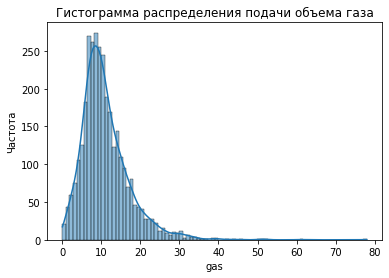

In [72]:
plot_distribution(data_gas, 'gas', title='Гистограмма распределения подачи объема газа')

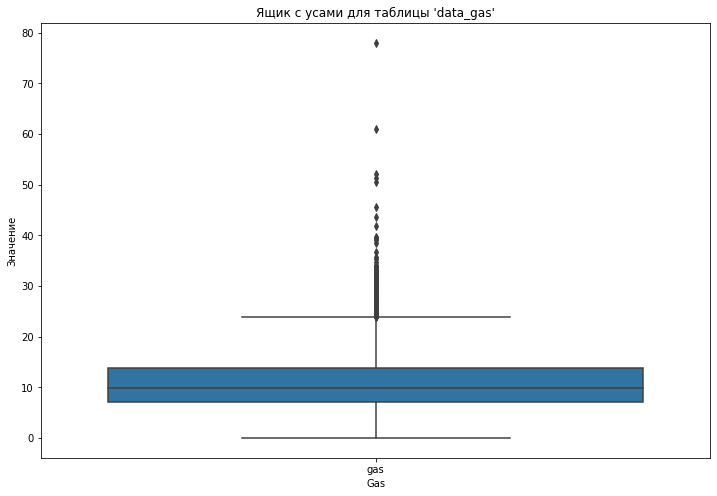

In [73]:
plt.figure(figsize=(12, 8))  # Размер графика
sns.boxplot(data=data_gas.iloc[:, 1:])  # Игнорируем столбец "key"
plt.title("Ящик с усами для таблицы 'data_gas'")  # Заголовок графика
plt.xlabel("Gas")  # Название оси X
plt.ylabel("Значение")  # Название оси Y
plt.show()  # Показать график

Распределение имеет довольно большой хвост и выбросы. Они могут исказить статистические характеристики выборки. Для усечения данных до трех сигм удалим значения, которые находятся за пределами интервала $(mean$ $value$ $-$ $3$ $*$ $std$ $value$, $mean$ $value$ $+$ $3$ $*$ $std$ $value)$ для столбца `gas`. Это позволит нам избавиться от выбросов и оставить только значения, которые находятся в пределах трех стандартных отклонений от среднего.

In [74]:
column_name = 'gas'
mean_value = data_gas[column_name].mean()
std_value = data_gas[column_name].std()
data_gas = data_gas[(data_gas[column_name] >= mean_value - 3 * std_value) & (data_gas[column_name] <= mean_value + 3 * std_value)]


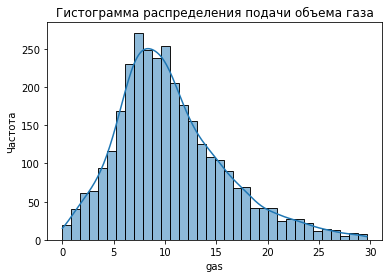

In [75]:
plot_distribution(data_gas, 'gas', title='Гистограмма распределения подачи объема газа')

Теперь таблица содержит только значения 'gas', находящиеся в пределах трех сигм от среднего

**Вывод:** Данные таблицы `data_gas` загружены, изучены и предобработаны для дальнейшей работы. Исследовано распределение данных, данные, выходящие за пределы 3 сигм отброшены

### Таблица data_temp

Таблица `data_temp` содержит данные об измерениях температуры. В данной таблице находится целевой признак

#### Первичное исследование data_temp

In [76]:
show_data('data_temp')
data_entries_len('data_temp')
count_null_values('data_temp')

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


Таблица data_temp имеет 15907 объектов


,key,MesaureTime,Temperature
Количество пропусков в столбце,0,0,2901


Пропусков в таблице нет

In [77]:
table_statistics('data_temp', ['Temperature'])

,min_value,max_value,mean_value,std_value,q1_value,median_value,q3_value
Temperature,1191.000,1705.000,1591.841,21.376,1581.000,1591.000,1601.000


Исходя из этой информации, можно сказать, что данные по температуре имеют относительно узкий диапазон значений, сконцентрированных вокруг среднего значения. Стандартное отклонение показывает небольшую изменчивость данных. Наличие значений квартилей позволяет сказать, что данные имеют относительно равномерное распределение внутри этого узкого диапазона

#### Предобработка и анализ data_temp

In [78]:
data_temp = download_data('data_temp')

In [79]:
data_temp = data_temp.rename(columns={'Temperature': 'temperature', 'MesaureTime': 'mesaure_time'})

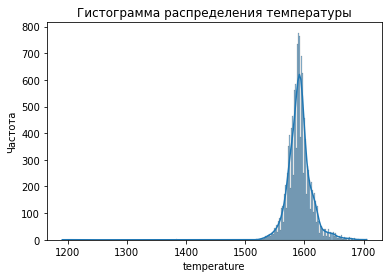

In [80]:
plot_distribution(data_temp, 'temperature', title='Гистограмма распределения температуры')

Здесь наблюдается нормальное распределение температуры с большим хвостом слева.

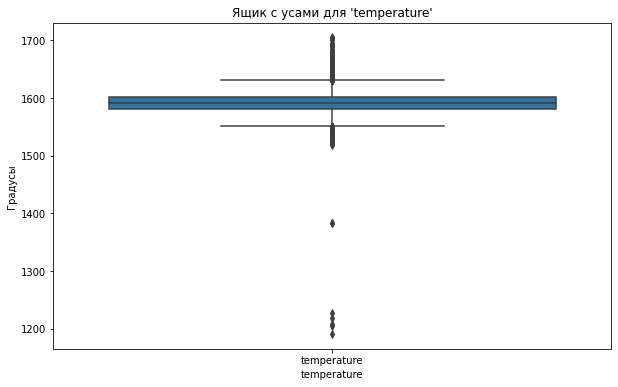

In [81]:
plt.figure(figsize=(10, 6))  # Размер графика
sns.boxplot(data=data_temp.iloc[:, 1:])  # Игнорируем столбец "key"
plt.title("Ящик с усами для 'temperature'")  # Заголовок графика
plt.xlabel("temperature")  # Название оси X
plt.ylabel("Градусы")  # Название оси Y
plt.show()  # Показать график

По условиям заказчика, значения температуры ниже 1500 градусов — аномальные, из необходимо исключить из датасета

In [82]:
data_temp.query('temperature < 1500')

,key,mesaure_time,temperature
4350,867,14:21:00,1191.0
5978,1214,05:32:00,1208.0
7958,1619,11:03:54,1218.0
8913,1818,00:30:49,1383.0
8914,1818,00:31:40,1383.0
10127,2052,14:51:40,1227.0
12564,2561,07:34:15,1204.0


In [83]:
data_temp = data_temp.query('temperature > 1500')

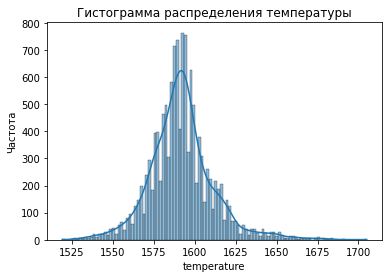

In [84]:
plot_distribution(data_temp, 'temperature', title='Гистограмма распределения температуры')

Теперь данные о распределении очищены от выбросов

Переведем данные о времени в секунды

In [85]:
data_temp['mesaure_time'] = data_temp['mesaure_time'].fillna('00:00:00').apply(time_to_seconds_2)

data_temp.head()

,key,mesaure_time,temperature
0,1,40578,1571.0
1,1,41153,1604.0
2,1,41351,1618.0
3,1,41401,1601.0
4,1,41439,1613.0


In [86]:
# Сортировка значений внутри каждой группы по столбцу 'MesaureTime'
data_temp = data_temp.groupby('key').apply(lambda x: x.sort_values(by='mesaure_time')).reset_index(drop=True)


In [87]:
data_temp.head(10)

,key,mesaure_time,temperature
0,1,40578,1571.0
1,1,41153,1604.0
2,1,41351,1618.0
3,1,41401,1601.0
4,1,41439,1613.0
5,2,41847,1581.0
6,2,41880,1577.0
7,2,42578,1589.0
8,2,42950,1604.0
9,2,43104,1608.0


По условиям проекта любые промежуточные значения температуры следует исключить, чтобы избежать утечки целевого признака. Также нужно использовать только ключи, у которых есть как минимум два наблюдения: первый и последний замеры температуры.У далим промежуточные замеры в каждой партии кроме первого и последнего.

Необходимо использовать последний замер в партии в качестве целевого признака, выделим ее в отдельный столбец:

In [88]:
for k in data_temp['key'].unique():
    idxs = []
    for i in data_temp[data_temp['key'] == k].index:
        idxs.append(i)
    if len(idxs) < 2:
        data_temp.drop(labels=idxs, axis=0, inplace=True)
    else:
        mid_idxs = idxs[1:-1]
        data_temp.drop(labels=mid_idxs, axis=0, inplace=True)

data_temp.reset_index(drop=True, inplace=True)

In [89]:
data_temp.head(10)

,key,mesaure_time,temperature
0,1,40578,1571.0
1,1,41439,1613.0
2,2,41847,1581.0
3,2,43152,1602.0
4,3,43997,1596.0
5,3,45297,1599.0
6,4,46377,1601.0
7,4,46765,1625.0
8,5,48199,1576.0
9,5,48961,1602.0


In [90]:
grouped_data_temp = data_temp.groupby('key').agg(
    first_measure_time=('mesaure_time', 'first'),
    first_temperature=('temperature', 'first'),
    last_measure_time=('mesaure_time', 'last'),
    last_temperature=('temperature', 'last')
).reset_index()

display(grouped_data_temp)

,key,first_measure_time,first_temperature,last_measure_time,last_temperature
0,1,40578,1571.0,41439,1613.0
1,2,41847,1581.0,43152,1602.0
2,3,43997,1596.0,45297,1599.0
3,4,46377,1601.0,46765,1625.0
4,5,48199,1576.0,48961,1602.0
...,...,...,...,...,...
2470,2495,2145,1570.0,3282,1591.0
2471,2496,3774,1554.0,5392,1591.0
2472,2497,6113,1571.0,6830,1589.0
2473,2498,7429,1591.0,8731,1594.0


In [91]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           4950 non-null   int64  
 1   mesaure_time  4950 non-null   int64  
 2   temperature   4950 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 116.1 KB


Изучим распределения признаков полученного датасета

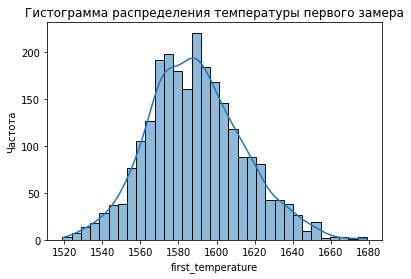

In [92]:
plot_distribution(grouped_data_temp, 'first_temperature', title='Гистограмма распределения температуры первого замера')

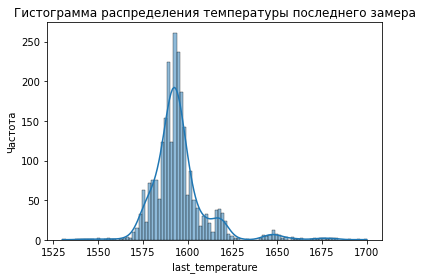

In [93]:
plot_distribution(grouped_data_temp, 'last_temperature', title='Гистограмма распределения температуры последнего замера')

Разница в распределениях может быть обусловлена особенностями самого процесса производства. Возможно, что в начале плавки температура находится в более стабильном состоянии или проходит через более предсказуемый этап, что приводит к более нормальному распределению первых замеров. В конце плавки могут возникать различные факторы, которые приводят к более нестабильной или менее предсказуемой температуре, что отражается в менее гладком распределении последних замеров. В процессе плавки стали может происходить изменение ее химического состава или примесей, что может повлиять на температуру плавления и охлаждения и может отразиться на распределении температур.

**Вывод:** Данные таблицы `data_temp` загружены, изучены и предобработаны для дальнейшей работы. Исследовано распределение данны, аномальные значения температуры отфильтрованы. Выделен целевой признак для обучения моделей, а данные сгруппированы по партиям.

### Таблица data_wire

Таблица **`data_wire` хранит данные об объёме проволочных материалов**

#### Первичное исследование data_wire

In [94]:
show_data('data_wire')
data_entries_len('data_wire')
count_null_values('data_wire')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,None,None,None,None,None,None,None
1,2,96.052315,NaN,None,None,None,None,None,None,None
2,3,91.160157,NaN,None,None,None,None,None,None,None
3,4,89.063515,NaN,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


Таблица data_wire имеет 3081 объектов


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
Количество пропусков в столбце,0,26,2002,3018,3067,3080,3008,3070,3062,3052


Таблица имеет небольшой размер, большинство ячеек не заполнены. Также можно отметить что не хватает указанных в описании столбцов c `Wire 10` по `Wire 15`

In [95]:
data_wire = download_data('data_wire')

In [96]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В таблице имеется 10 колонок и 3081 строк с типами данных `int64` и `float64`

#### Предобработка и анализ data_wire

In [98]:
data_wire = data_wire.rename(columns={'Wire 1': 'wire_1', 'Wire 2': 'wire_2', 'Wire 3': 'wire_3', 'Wire 4': 'wire_4', 'Wire 5': 'wire_5', 'Wire 6': 'wire_6',
       'Wire 7': 'wire_7', 'Wire 8': 'wire_8', 'Wire 9': 'wire_9'})

In [99]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Видно, что для некоторых проволочных материалов имеется меньше данных (например, для Wire 3, Wire 4, Wire 5, Wire 6, Wire 7, Wire 8, и Wire 9)

Исследуем распределения признаков:

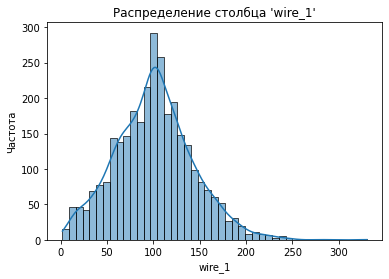

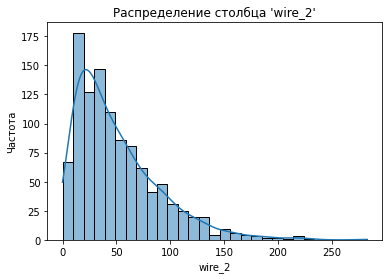

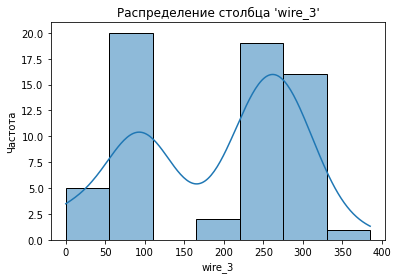

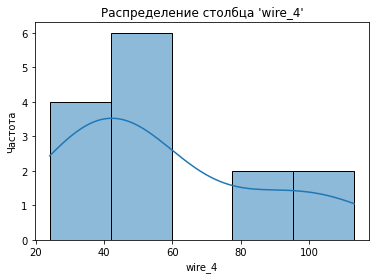

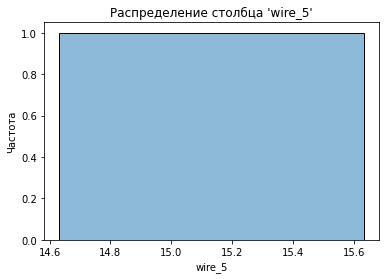

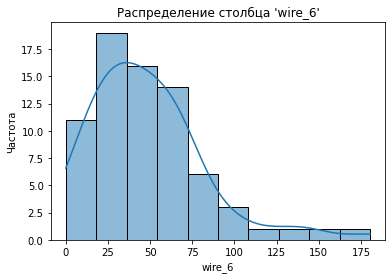

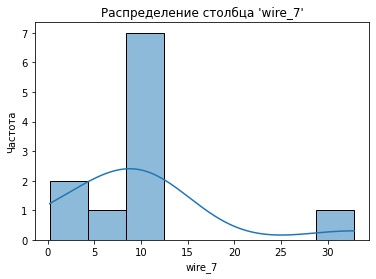

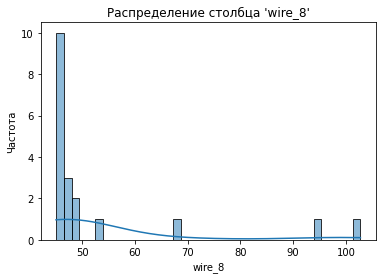

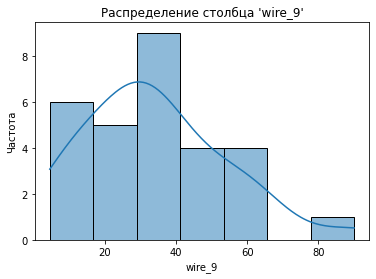

In [100]:
for col in data_wire.columns:
    if col == 'key':
        continue
    plot_distribution(data_wire, col)

Первые два столбца имеют достаточно большое количество данных и их распределения стремятся к нормальному. Остальные проволочные материалы используются редко.

Заполним пропуски материалов нулями, которые будут означать, что проволочные материалы не добавлялись в сплав:

In [101]:
data_wire = data_wire.fillna(0)

In [102]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Пропуски заполнены

**Вывод:** Данные таблицы `data_wire` загружены, изучены и предобработаны для дальнейшей работы. Исследовано распределение данны, пропусщенные значения заполнены.

### Таблица data_wire_time

Таблица **`data_wire_time` — это данные о времени подачи проволочных материалов.**

#### Первичное исследование data_wire_time


- [ ] Провести исследовательский анализ данных: проверить наличие пропусков и аномалий, изучить распределение признаков.
- [ ] Проверить данные на адекватность, чтобы убедиться, что подача материала не измеряется сутками. Учесть, что перед вами не стоит задача временных рядов.

In [104]:
show_data('data_wire_time')
data_entries_len('data_wire_time')
count_null_values('data_wire_time')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


Таблица data_wire_time имеет 3081 объектов


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
Количество пропусков в столбце,0,26,2002,3018,3067,3080,3008,3070,3062,3052


In [105]:
data_wire_time = download_data('data_wire_time')

In [106]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


#### Предобработка и анализ data_wire_time

In [107]:
data_wire_time = data_wire_time.rename(columns={'Wire 1': 'wire_1', 'Wire 2': 'wire_2', 'Wire 3': 'wire_3', 'Wire 4': 'wire_4', 'Wire 5': 'wire_5', 'Wire 6': 'wire_6',
       'Wire 7': 'wire_7', 'Wire 8': 'wire_8', 'Wire 9': 'wire_9'})

In [108]:
for col in data_wire_time.columns[1:]:
    data_wire_time[col] = data_wire_time[col].apply(time_to_seconds_2)


In [109]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,40301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,42370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,44027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,46085.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,47895.0,48726.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


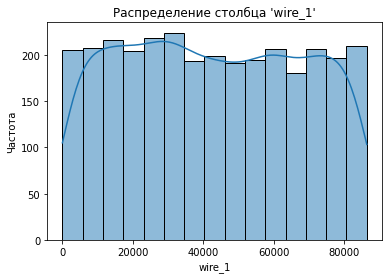

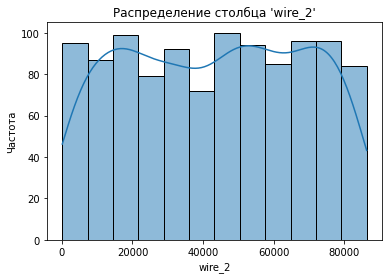

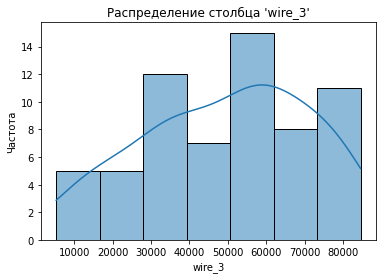

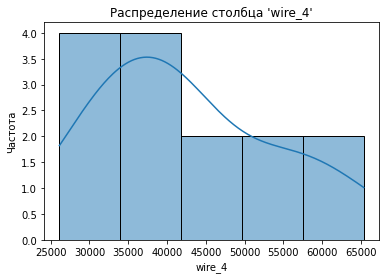

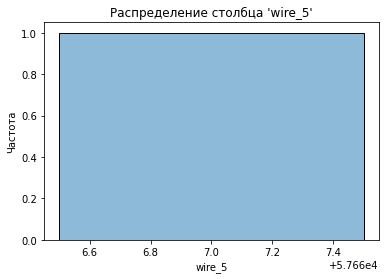

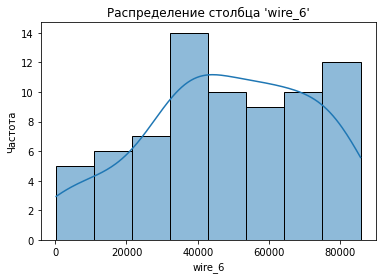

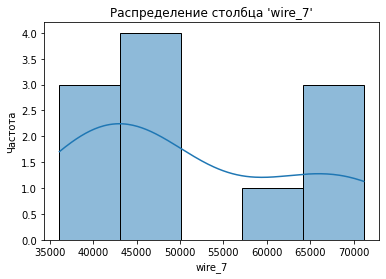

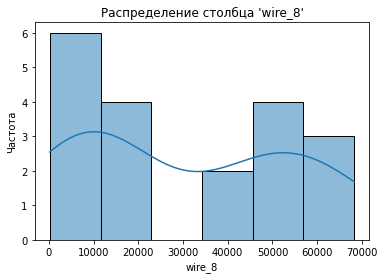

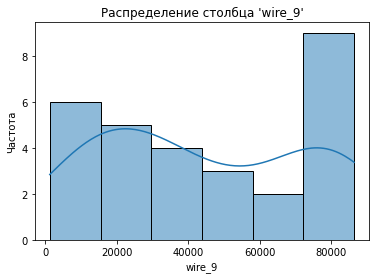

In [110]:
for col in data_wire_time.columns:
    if col == 'key':
        continue
    plot_distribution(data_wire_time, col)


In [111]:
data_bulk_time.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,45831.746032,46757.272727,43949.822804,40960.462525,41242.389610,43950.003472,39905.040000,63971.0,30507.368421,40771.465909,44919.192090,42310.439592,50406.722222,42624.291875,42014.434609
std,933.337642,23020.503525,11585.371224,24805.005912,24659.858787,26658.390938,25345.768281,14118.697029,NaN,24064.491668,23321.214749,24075.961031,25125.733658,27306.315875,25078.684065,25187.678411
min,1.000000,13.000000,30979.000000,1.000000,38.000000,93.000000,85.000000,2558.000000,63971.0,296.000000,61.000000,1709.000000,60.000000,2375.000000,11.000000,60.000000
25%,816.000000,29101.000000,36845.000000,23182.750000,19594.000000,16072.000000,21692.000000,31588.000000,63971.0,9443.500000,22999.500000,23670.000000,20252.500000,30889.750000,20831.000000,20046.500000
50%,1622.000000,47709.000000,42723.000000,43148.000000,38613.000000,40138.000000,43845.000000,40220.000000,63971.0,18906.000000,39071.000000,43044.000000,41802.000000,61091.000000,41915.000000,40932.000000
75%,2431.000000,62292.750000,56616.500000,65734.500000,61450.750000,64910.000000,67060.000000,50753.000000,63971.0,51228.500000,59397.500000,65269.000000,64166.250000,73097.000000,64492.250000,64271.750000
max,3241.000000,86064.000000,64910.000000,86252.000000,86370.000000,85354.000000,86175.000000,64910.000000,63971.0,68281.000000,84770.000000,86175.000000,86334.000000,84845.000000,86334.000000,86334.000000


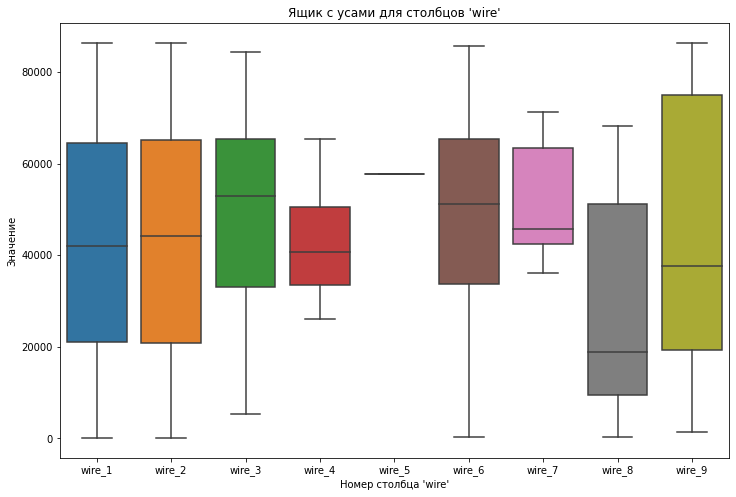

In [112]:
# Построение графика "ящик с усами"
plt.figure(figsize=(12, 8))  # Размер графика
sns.boxplot(data=data_wire_time.iloc[:, 1:])  # Игнорируем столбец "key"
plt.title("Ящик с усами для столбцов 'wire'")  # Заголовок графика
plt.xlabel("Номер столбца 'wire'")  # Название оси X
plt.ylabel("Значение")  # Название оси Y
plt.show()  # Показать график

**Проверка адекватности даннызх**

In [113]:
for col in data_wire_time.columns:
  print(f'Количество значений в столбце {col} больше 86400 секунд: ',
        data_wire_time.query(f'{col} > 86400')[col].count())

Количество значений в столбце key больше 86400 секунд:  0
Количество значений в столбце wire_1 больше 86400 секунд:  0
Количество значений в столбце wire_2 больше 86400 секунд:  0
Количество значений в столбце wire_3 больше 86400 секунд:  0
Количество значений в столбце wire_4 больше 86400 секунд:  0
Количество значений в столбце wire_5 больше 86400 секунд:  0
Количество значений в столбце wire_6 больше 86400 секунд:  0
Количество значений в столбце wire_7 больше 86400 секунд:  0
Количество значений в столбце wire_8 больше 86400 секунд:  0
Количество значений в столбце wire_9 больше 86400 секунд:  0


Все данные по времени находятся в пределах 86400 секунд

### Выводы

Все предоставленные таблицы загружены и исследованы. Таблицы предоставлены в количестве соответствующем описанию, но в таблицах с данными о проволочных материалах обнаружено скорее всего некритичное несоответствие предоставленному описанию данных. Произведена необходимая предобработка датасетов, исследованы и/или удалены пропуски, изучены распределения данных. Удалены выбросы. Добавлены новые признаки обучения моделей.

## Формирование финального датасета

Объединение таблиц будет проходить согласно следующим принципам:

* Каждой партии соответствовует одно наблюдение.
* Далее будет провелен иследовательский анализ данных объединённой таблицы и визуализация распределения каждого признака, а также корреляционный анализ признаков.

In [114]:
data_arc = data_arc.rename(columns={'total_general_energy': 'total_energy', 'total_heat_duration_in_seconds': 'heat_time_sec'})

In [115]:
data_arc.columns

Index(['key', 'begin_heat_sec', 'end_heat_sec', 'general_power',
       'general_energy', 'total_active_power', 'total_reactive_power',
       'total_energy', 'heat_time_sec', 'total_ratio_active_reactive'],
      dtype='object')

In [116]:
data_arc_total = data_arc.drop_duplicates(subset='key')[['key', 'total_energy', 'heat_time_sec', 'total_active_power', 'total_reactive_power', 'total_ratio_active_reactive']].reset_index(drop=True)

In [117]:
data_arc_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          3214 non-null   int64  
 1   total_energy                 3214 non-null   float64
 2   heat_time_sec                3214 non-null   float64
 3   total_active_power           3214 non-null   float64
 4   total_reactive_power         3214 non-null   float64
 5   total_ratio_active_reactive  3214 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 150.8 KB


In [118]:
display(data_arc_total.head())

,key,total_energy,heat_time_sec,total_active_power,total_reactive_power,total_ratio_active_reactive
0,1,1442.377754,1098.0,4.878147,3.183241,1.532447
1,2,881.233565,811.0,3.052598,1.998112,1.527741
2,3,525.066777,655.0,2.525882,1.599076,1.579589
3,4,796.911309,741.0,3.209250,2.060298,1.557663
4,5,1199.137958,869.0,3.347173,2.252643,1.485887


Отфильтруем все признаки в таблице data_wire, чтобы исключить строки с нулевыми значениями

In [119]:
data_wire_filtered = filter_rows_with_data(data_wire, 'key')

In [120]:
display(data_wire_filtered.head())

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
(data_wire.copy().drop(columns=['key']).sum(axis=1) < 1.0e-8).sum()
(data_bulk.copy().drop(columns=['key']).sum(axis=1) < 1.0e-8).sum()

0

In [122]:
data_wire_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 264.8 KB


In [123]:
X = grouped_data_temp.merge(data_arc_total, on='key')
X = X.merge(data_wire, on='key')
X = X.merge(data_gas, on='key')
X = X.merge(data_bulk, on='key')

In [124]:
display(X)

,key,first_measure_time,first_temperature,last_measure_time,last_temperature,total_energy,heat_time_sec,total_active_power,total_reactive_power,total_ratio_active_reactive,...,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,2,41847,1581.0,43152,1602.0,881.233565,811.0,3.052598,1.998112,1.527741,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
1,3,43997,1596.0,45297,1599.0,525.066777,655.0,2.525882,1.599076,1.579589,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
2,4,46377,1601.0,46765,1625.0,796.911309,741.0,3.209250,2.060298,1.557663,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
3,5,48199,1576.0,48961,1602.0,1199.137958,869.0,3.347173,2.252643,1.485887,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
4,6,49764,1543.0,51149,1596.0,1410.747219,952.0,3.955108,2.689175,1.470751,...,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,2495,2145,1570.0,3282,1591.0,778.818234,723.0,3.210690,2.360777,1.360014,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2284,2496,3774,1554.0,5392,1591.0,875.261419,940.0,4.203064,2.810185,1.495654,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2285,2497,6113,1571.0,6830,1589.0,556.930349,569.0,2.212379,1.851269,1.195061,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2286,2498,7429,1591.0,8731,1594.0,767.817794,750.0,3.408725,2.355428,1.447179,...,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0


In [125]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 0 to 2287
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          2288 non-null   int64  
 1   first_measure_time           2288 non-null   int64  
 2   first_temperature            2288 non-null   float64
 3   last_measure_time            2288 non-null   int64  
 4   last_temperature             2288 non-null   float64
 5   total_energy                 2288 non-null   float64
 6   heat_time_sec                2288 non-null   float64
 7   total_active_power           2288 non-null   float64
 8   total_reactive_power         2288 non-null   float64
 9   total_ratio_active_reactive  2288 non-null   float64
 10  wire_1                       2288 non-null   float64
 11  wire_2                       2288 non-null   float64
 12  wire_3                       2288 non-null   float64
 13  wire_4            

In [126]:
X.tail()

,key,first_measure_time,first_temperature,last_measure_time,last_temperature,total_energy,heat_time_sec,total_active_power,total_reactive_power,total_ratio_active_reactive,...,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2283,2495,2145,1570.0,3282,1591.0,778.818234,723.0,3.210690,2.360777,1.360014,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2284,2496,3774,1554.0,5392,1591.0,875.261419,940.0,4.203064,2.810185,1.495654,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2285,2497,6113,1571.0,6830,1589.0,556.930349,569.0,2.212379,1.851269,1.195061,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2286,2498,7429,1591.0,8731,1594.0,767.817794,750.0,3.408725,2.355428,1.447179,...,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0
2287,2499,9625,1569.0,10828,1603.0,1301.828445,883.0,4.098431,2.777865,1.475389,...,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0


Визуально похоже, что ключей больше 2499 не осталось, но убедимся в этом на всякий случай, проверив значение максимального ключа:

In [127]:
max_key = X['key'].max()
print("Значение максимального ключа:", max_key)

Значение максимального ключа: 2499


Убедимся, что все замеры температуры известны и были произведены корректно. Для этого можно проверить, нет ли совпадений первого и последнего времени замера:

In [128]:
if X['key'].duplicated().any():
    print("В столбце key есть дубликаты.")
else:
    print("В столбце key нет дубликатов.")

В столбце key нет дубликатов.


In [129]:
# Проверка на совпадение времени первого и последнего замера
ids_equal_time = X[X['first_measure_time'] == X['last_measure_time']]['key'].tolist()

# Проверка на отсутствие данных по первому или последнему замеру
ids_no_measure = X[(X['first_measure_time'].isna() | (X['first_measure_time'] == 0) | X['last_measure_time'].isna() | (X['last_measure_time'] == 0))]['key'].tolist()

if ids_equal_time and ids_no_measure:
    print(f'Для партий {", ".join(map(str, ids_equal_time))} время первого замера совпадает с последним!')
    print(f'Для партий {", ".join(map(str, ids_no_measure))} нет данных по первому или последнему замеру!')
elif ids_equal_time:
    print(f'Для партий {", ".join(map(str, ids_equal_time))} время первого замера совпадает с последним!')
elif ids_no_measure:
    print(f'Для партий {", ".join(map(str, ids_no_measure))} нет данных по первому или последнему замеру!')
else:
    print('Все замеры температуры известны и были произведены корректно.')


Все замеры температуры известны и были произведены корректно.


In [130]:
# В этих признаках недостаточно данных: Wire 5, Wire 7, Bulk 8 - удалим их, т.к. они влияют на качество
(X.abs() > 1.0e-8).sum() < 10

key                            False
first_measure_time             False
first_temperature              False
last_measure_time              False
last_temperature               False
total_energy                   False
heat_time_sec                  False
total_active_power             False
total_reactive_power           False
total_ratio_active_reactive    False
wire_1                         False
wire_2                         False
wire_3                         False
wire_4                          True
wire_5                          True
wire_6                         False
wire_7                          True
wire_8                         False
wire_9                         False
gas                            False
bulk_1                         False
bulk_2                          True
bulk_3                         False
bulk_4                         False
bulk_5                         False
bulk_6                         False
bulk_7                          True
b

In [131]:
X = X.drop(columns=['wire_5', 'wire_7', 'bulk_8'])

In [132]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 0 to 2287
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          2288 non-null   int64  
 1   first_measure_time           2288 non-null   int64  
 2   first_temperature            2288 non-null   float64
 3   last_measure_time            2288 non-null   int64  
 4   last_temperature             2288 non-null   float64
 5   total_energy                 2288 non-null   float64
 6   heat_time_sec                2288 non-null   float64
 7   total_active_power           2288 non-null   float64
 8   total_reactive_power         2288 non-null   float64
 9   total_ratio_active_reactive  2288 non-null   float64
 10  wire_1                       2288 non-null   float64
 11  wire_2                       2288 non-null   float64
 12  wire_3                       2288 non-null   float64
 13  wire_4            

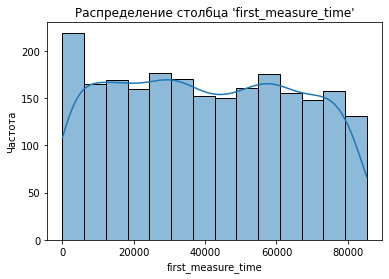

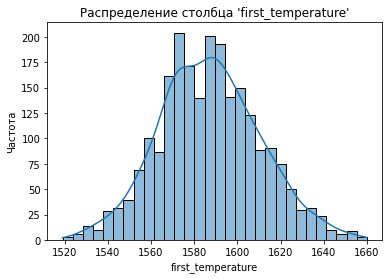

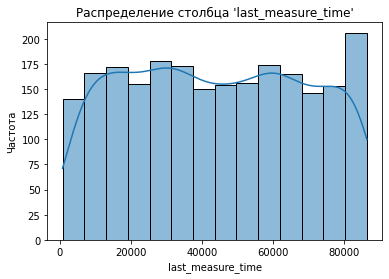

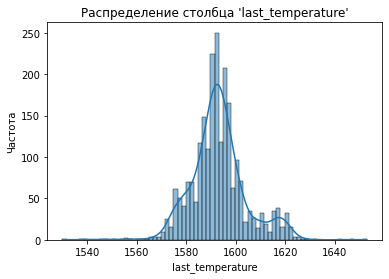

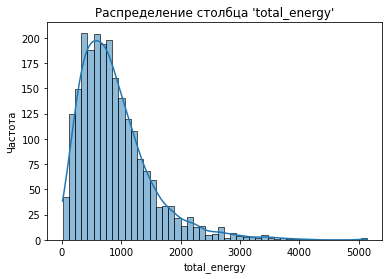

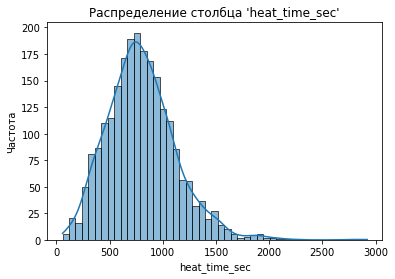

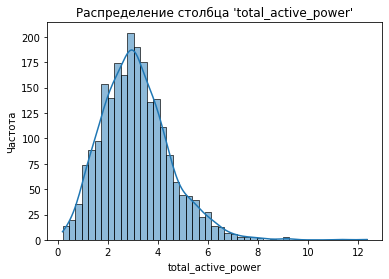

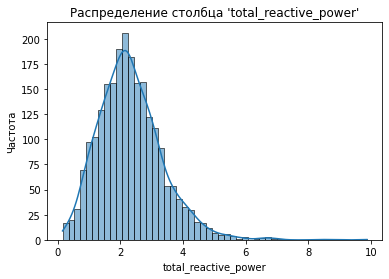

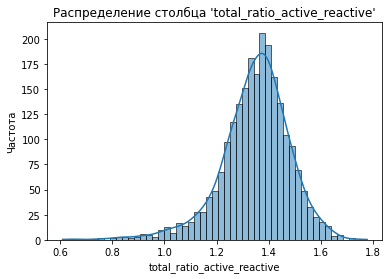

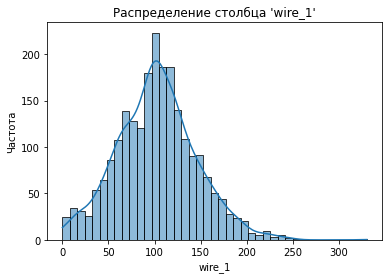

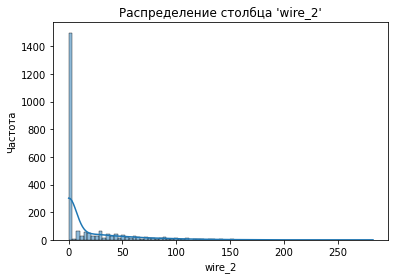

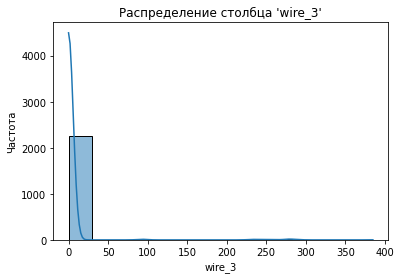

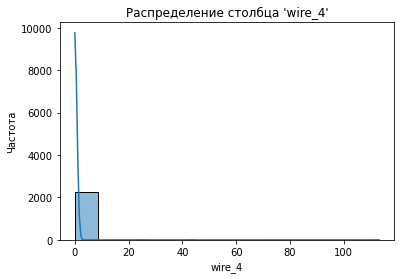

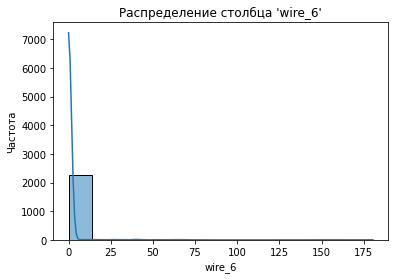

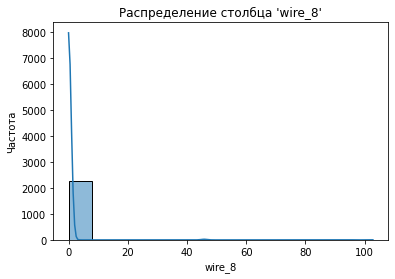

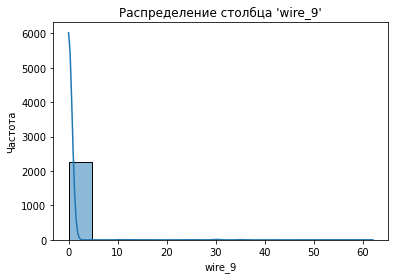

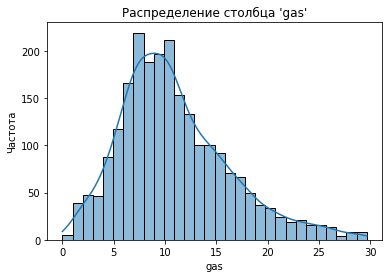

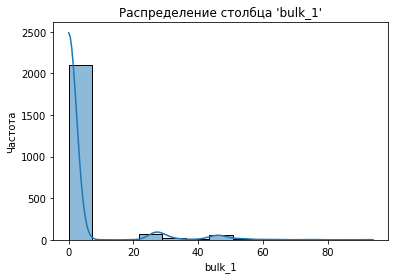

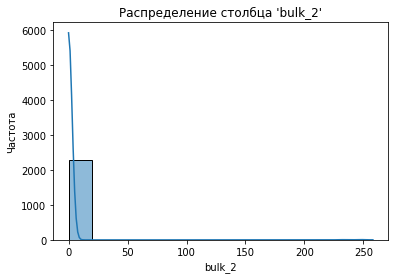

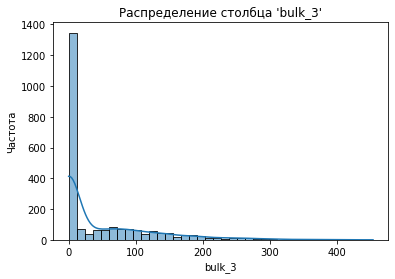

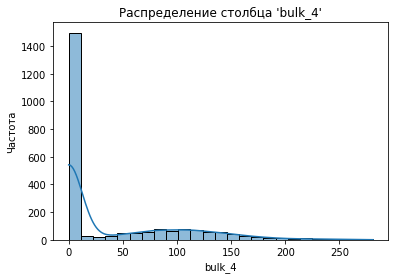

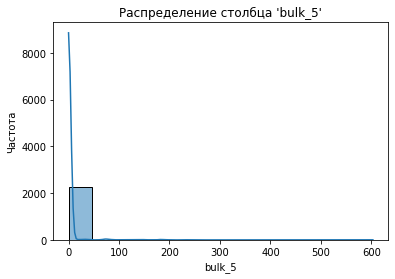

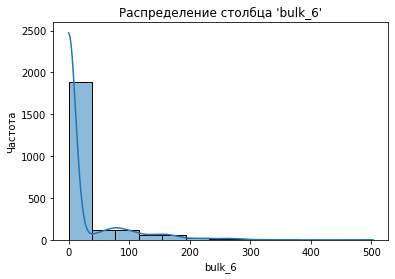

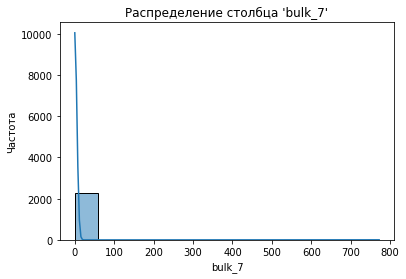

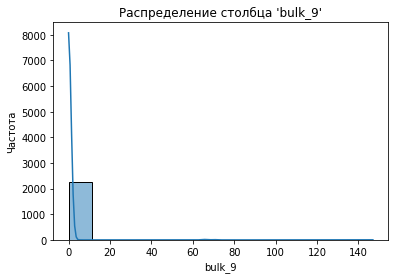

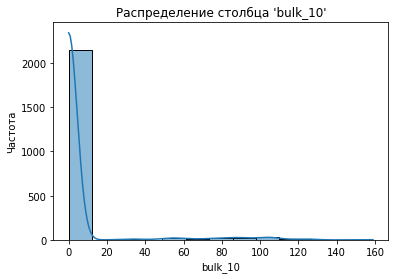

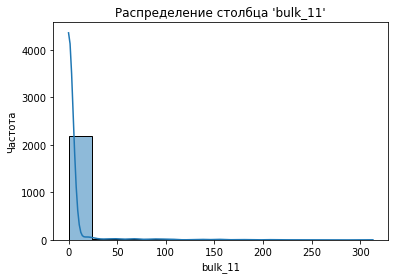

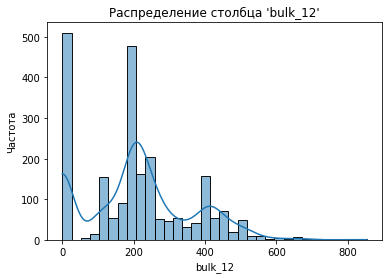

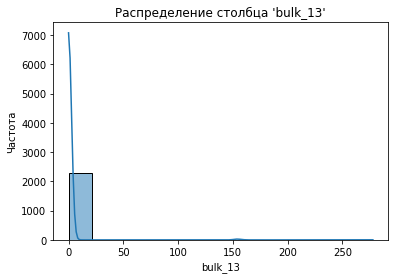

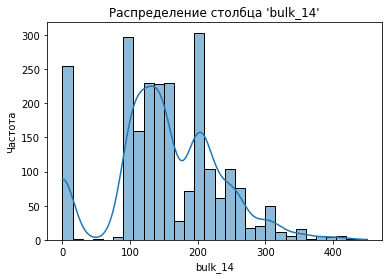

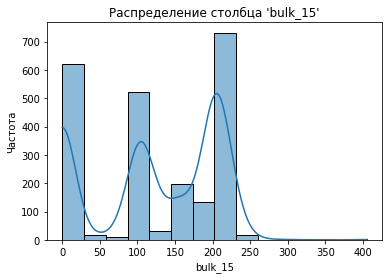

In [133]:
for col in X.columns:
    if col == 'key':
        continue
    plot_distribution(X, col)

Признаки финального датасета в основном имеют распределение похожее на нормальное, на исключением признаков сыпучих смесей и проволочных материалов, так как они часто вносятся неравноерно и в малых количествах.

In [134]:
y = X['last_temperature'] # последняя температура партии - целевой признак, будет исключен из финального датасета

Также нустановим признак `key` в качестве индексации таблицы

In [135]:
X = X.set_index('key')

In [136]:
X.head()

,first_measure_time,first_temperature,last_measure_time,last_temperature,total_energy,heat_time_sec,total_active_power,total_reactive_power,total_ratio_active_reactive,wire_1,...,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,,,,,,,
2,41847,1581.0,43152,1602.0,881.233565,811.0,3.052598,1.998112,1.527741,96.052315,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,43997,1596.0,45297,1599.0,525.066777,655.0,2.525882,1.599076,1.579589,91.160157,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,46377,1601.0,46765,1625.0,796.911309,741.0,3.209250,2.060298,1.557663,89.063515,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,48199,1576.0,48961,1602.0,1199.137958,869.0,3.347173,2.252643,1.485887,89.238236,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
6,49764,1543.0,51149,1596.0,1410.747219,952.0,3.955108,2.689175,1.470751,99.109917,...,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0


Проведем корелляционный анализ финального датасета:

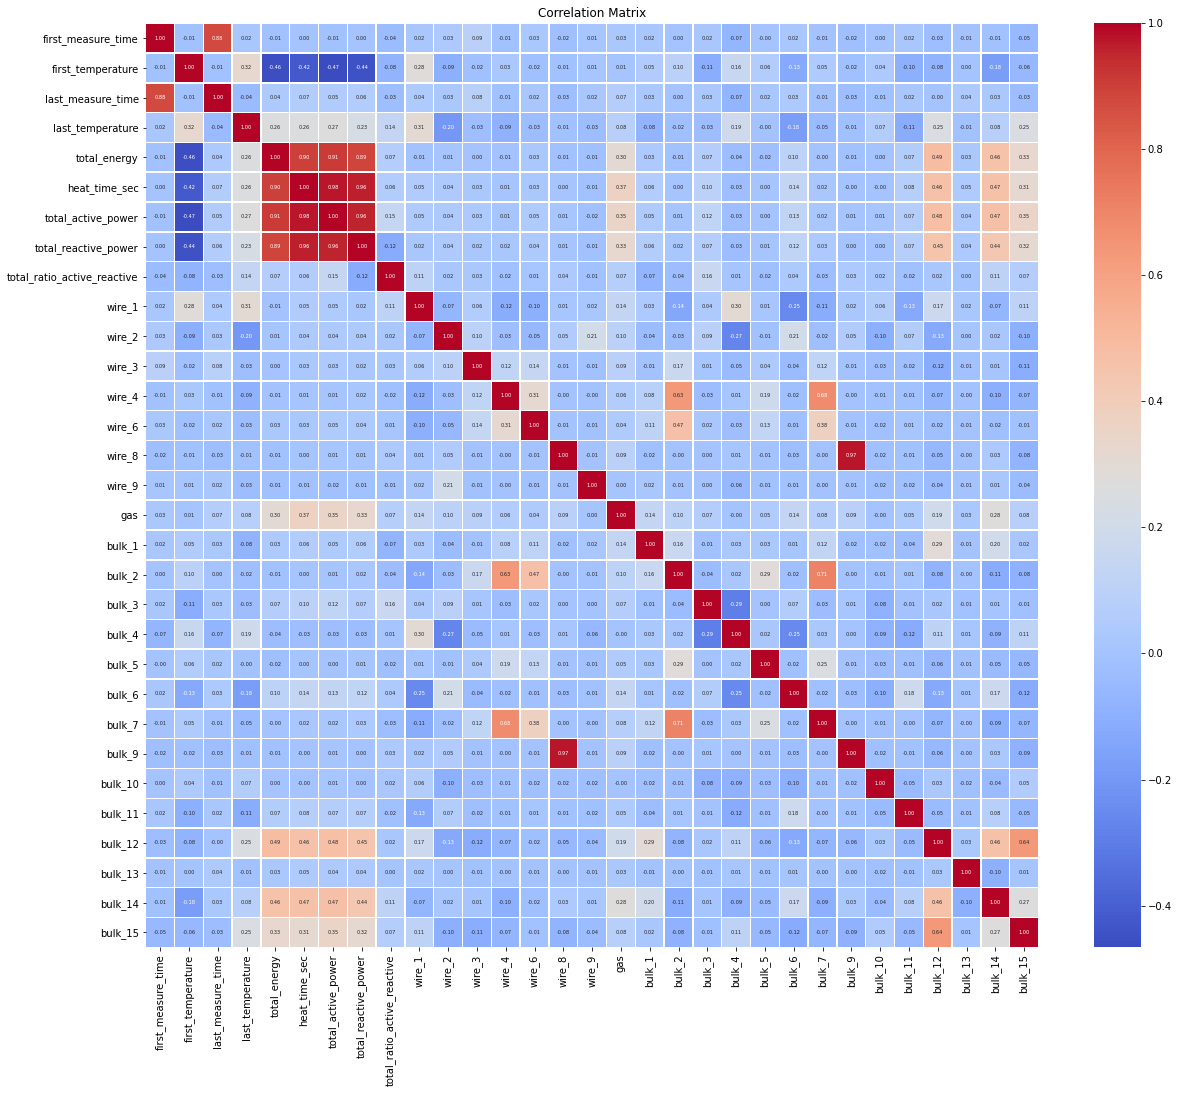

In [137]:
correlation_matrix = X.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(20, 17))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={'size': 5})
plt.title('Correlation Matrix')
plt.show()

Сильные положительные корреляции:

* "total_active_power" и "total_reactive_power" имеют очень высокую положительную корреляцию (примерно 0.96). Это говорит о том, что активная и реактивная мощности сильно связаны между собой. Это логично, так как в электрических системах обычно существует высокая зависимость между активной мощностью (которая используется для выполнения работы) и реактивной мощностью (которая не выполняет работы, но необходима для обслуживания некоторых элементов системы).

* "first_measure_time" и "last_measure_time" имеют высокую положительную корреляцию (примерно 0.87). Это говорит о том, что время первого измерения и время последнего измерения сильно связаны. Это может указывать на то, что некоторый процесс начинается и заканчивается в определенные временные интервалы, и, возможно, имеет регулярную или циклическую природу.

* На диагонали (самокорреляция каждого признака с самим собой) значение всегда равно 1, так как признак полностью коррелирует с самим собой.

Сильные отрицательные корреляции:

* "total_energy" и "first_temperature" имеют относительно сильную отрицательную корреляцию (примерно -0.42). Это означает, что с увеличением потребления энергии первая измеренная температура обычно снижается. Такая связь может указывать на тепловые свойства процесса: чем больше энергии потребляется, тем больше тепла выделяется, что приводит к снижению начальной температуры.

* "total_energy" и "last_temperature" также имеют отрицательную корреляцию (примерно -0.24). Это означает, что с увеличением потребления энергии последняя измеренная температура обычно снижается. Это подтверждает наблюдение из предыдущей связи; увеличение энергии в процессе приводит к большему выделению тепла и, как следствие, к снижению температуры к концу процесса.

Другие наблюдения:

* Некоторые пары признаков имеют очень слабую корреляцию, близкую к нулю, что может указывать на отсутствие линейной связи между ними.

Исключим абсолютные данные по времени из признаков. Абсолютное время вряд ли повлияет на обучение модели т.к. неинформативно.

In [138]:
X = X.drop(['last_temperature', 'last_measure_time', 'first_measure_time'], axis=1)

Теперь предстоит подготовить данные для обучения:


Разделить данные на тренировочную и тестовую выборки с помощью метода test_size = 0.25.


Подготовить выборки для обучения, учитывая особенности выбранных моделей.

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=RANDOM_STATE)

In [140]:
X_train.head()

,first_temperature,total_energy,heat_time_sec,total_active_power,total_reactive_power,total_ratio_active_reactive,wire_1,wire_2,wire_3,wire_4,...,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,,,,,,,
1839,1588.0,376.413908,518.0,1.909088,1.370916,1.392563,92.008789,120.097122,282.089813,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257,1591.0,867.552707,907.0,3.290322,3.918495,0.839690,120.135598,0.000000,0.000000,0.0,...,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,0.0
1772,1577.0,622.260278,678.0,2.493101,1.859125,1.341008,47.080799,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,102.0,103.0
2029,1543.0,2563.474834,1315.0,5.019936,5.450338,0.921032,59.142723,0.000000,0.000000,0.0,...,0.0,131.0,0.0,0.0,0.0,67.0,517.0,0.0,351.0,105.0
1080,1579.0,1005.752254,725.0,3.139769,2.239747,1.401841,73.101601,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,124.0,204.0


In [141]:
X_train.head()

,first_temperature,total_energy,heat_time_sec,total_active_power,total_reactive_power,total_ratio_active_reactive,wire_1,wire_2,wire_3,wire_4,...,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,,,,,,,
1839,1588.0,376.413908,518.0,1.909088,1.370916,1.392563,92.008789,120.097122,282.089813,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257,1591.0,867.552707,907.0,3.290322,3.918495,0.839690,120.135598,0.000000,0.000000,0.0,...,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.0,0.0
1772,1577.0,622.260278,678.0,2.493101,1.859125,1.341008,47.080799,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,102.0,103.0
2029,1543.0,2563.474834,1315.0,5.019936,5.450338,0.921032,59.142723,0.000000,0.000000,0.0,...,0.0,131.0,0.0,0.0,0.0,67.0,517.0,0.0,351.0,105.0
1080,1579.0,1005.752254,725.0,3.139769,2.239747,1.401841,73.101601,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,124.0,204.0


In [142]:
print('Размер тренировочных признаков', X_train.shape)

Размер тренировочных признаков (1716, 28)


In [143]:
print('Размер тренировочных плейблов', y_train.shape)

Размер тренировочных плейблов (1716,)


In [144]:
X_test.head()

,first_temperature,total_energy,heat_time_sec,total_active_power,total_reactive_power,total_ratio_active_reactive,wire_1,wire_2,wire_3,wire_4,...,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,,,,,,,
2057,1578.0,935.768018,990.0,3.907077,3.110802,1.255971,30.051840,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,0.0,103.0
202,1605.0,840.541024,724.0,3.125045,2.206605,1.416223,105.006721,9.143681,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,561.0,0.0,213.0,205.0
738,1573.0,432.765127,688.0,2.382306,1.738764,1.370115,145.360798,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.0,0.0
2277,1568.0,991.160662,1173.0,4.412719,3.448853,1.279474,76.046883,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,208.0,0.0,0.0,105.0
616,1561.0,1150.921562,1075.0,4.030782,3.178482,1.268147,152.333993,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,101.0,202.0


In [145]:
print('Размер тестовых признаков', X_test.shape)

Размер тестовых признаков (572, 28)


In [146]:
y_test.head()

1892    1598.0
174     1588.0
665     1582.0
2091    1588.0
555     1597.0
Name: last_temperature, dtype: float64

In [147]:
print('Размер тренировочных плейблов', y_test.shape)

Размер тренировочных плейблов (572,)


### Выводы

Из предобработанных данных был сформирован финальный датасет, исследовано распределение данных данного датасета, а также проведен корелляционный анализ. Данные разделены на тренировочную и тестовые выборки и готовы к обучению моделей

## Обучение моделей

Здесь рассмотрим классы моделей:
1. решающее дерево
2. случайный лес
3. котбустинг
4. нейронные сети.

Найдем лучшую модель для прогноза последней измеренной температуры. Оценим её качество метрикой **MAE**. Выберем лучшую модель по значению метрики на кросс-валидации.
Подберем значения нескольким гиперпараметрам для наших моделей с помощью RandomizedSearchCV и GridSearchCV.

В эти списки будем сохранять модели с лучшими параметрами на кросвалицации и их соответствующие скоры, чтобы затем протестировать лучшие

In [148]:
all_models = []
all_scores = []

### Decision Tree

In [149]:
tree_params = {
    'max_depth': range(4, 30, 4),
    'min_samples_leaf': [2, 130, 4],
}

grid_tree = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE), tree_params, n_jobs=2, cv=4, scoring='neg_mean_absolute_error')
result_tree = grid_tree.fit(X_train, y_train)

In [150]:
model_tree = result_tree.best_estimator_

In [151]:
result_tree.best_params_

{'max_depth': 8, 'min_samples_leaf': 2}

In [152]:
mae_tree = -result_tree.best_score_
print(mae_tree)

7.3522964430839854


In [153]:
all_models.append(model_tree)
all_scores.append(mae_tree)

### Random Forest

In [154]:
# Создаем модель RandomForest
rfr = RandomForestRegressor(random_state=RANDOM_STATE)

# Задаем параметры для перебора
rf_param = {'n_estimators': randint(50, 100),
              'max_features': [None],
              'max_depth': [4, 10, 20, 30, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'criterion' : ['mae']
             }

# Создаем объект RandomizedSearchCV
random_search = RandomizedSearchCV(rfr, param_distributions=rf_param,
                                   n_iter=10, cv=5, scoring='neg_mean_absolute_error', verbose=4)

# Обучаем модель на обучающей выборке
random_search.fit(X_train, y_train)

# Выводим наилучшие параметры и оценку качества модели
print("Best parameters: {}".format(random_search.best_params_))
print("Best MAE: {:.2f}".format(-random_search.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=mae, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=87; total time=  32.8s
[CV 2/5] END criterion=mae, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=87; total time=  34.2s
[CV 3/5] END criterion=mae, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=87; total time=  35.2s
[CV 4/5] END criterion=mae, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=87; total time=  31.0s
[CV 5/5] END criterion=mae, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=87; total time=  37.2s
[CV 1/5] END criterion=mae, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=85; total time=  27.3s
[CV 2/5] END criterion=mae, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=2, n_esti

In [155]:
all_models.append(random_search.best_estimator_)
all_scores.append(-random_search.best_score_)

### Catboost

In [156]:
cat = catboost.CatBoostRegressor(eval_metric='MAE', random_state=RANDOM_STATE)

cat_grid = {'learning_rate': [0.001, 0.005, 0.01, 0.1],
            'depth': [4, 6, 8, 10, 12],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'n_estimators': [500, 1000]}

randomized_search_result = cat.randomized_search(cat_grid,
                                                 X=X_train,
                                                 y=y_train,
                                                 plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1591.6009887	test: 1591.7625197	best: 1591.7625197 (0)	total: 51.9ms	remaining: 51.9s
1:	learn: 1590.0909611	test: 1590.2558011	best: 1590.2558011 (1)	total: 54.3ms	remaining: 27.1s
2:	learn: 1588.5385926	test: 1588.7018006	best: 1588.7018006 (2)	total: 56.6ms	remaining: 18.8s
3:	learn: 1586.9802001	test: 1587.1440758	best: 1587.1440758 (3)	total: 58.4ms	remaining: 14.5s
4:	learn: 1585.4512515	test: 1585.6193676	best: 1585.6193676 (4)	total: 59.8ms	remaining: 11.9s
5:	learn: 1583.9633453	test: 1584.1400145	best: 1584.1400145 (5)	total: 61.2ms	remaining: 10.1s
6:	learn: 1582.4194176	test: 1582.5912333	best: 1582.5912333 (6)	total: 62.5ms	remaining: 8.87s
7:	learn: 1580.9169113	test: 1581.0888612	best: 1581.0888612 (7)	total: 63.9ms	remaining: 7.92s
8:	learn: 1579.3998468	test: 1579.5686738	best: 1579.5686738 (8)	total: 65.4ms	remaining: 7.2s
9:	learn: 1577.8363872	test: 1578.0053012	best: 1578.0053012 (9)	total: 66ms	remaining: 6.53s
10:	learn: 1576.2962806	test: 1576.4673137	

In [157]:
mae_cat = cat.get_best_score()
print(cat.get_best_score())

{'learn': {'MAE': 4.705828634275287, 'RMSE': 6.242833286507694}}


In [158]:
cat_best_params = randomized_search_result['params']
print(cat_best_params)

{'depth': 6, 'l2_leaf_reg': 1, 'iterations': 1000, 'learning_rate': 0.01}


In [159]:
cat_model = catboost.CatBoostRegressor(**cat_best_params, eval_metric='MAE', random_state=RANDOM_STATE)

In [160]:
cat_model = catboost.CatBoostRegressor(cat_best_params, random_state=RANDOM_STATE)
all_models.append(cat_model)
all_scores.append(mae_cat['learn']['MAE'])

### Нейронная сеть

In [161]:
n_valid = int(0.25 * len(X_train))

TX_train = torch.tensor(X_train.to_numpy()).float()
TX_valid = TX_train[:n_valid]
TX_train = TX_train[n_valid:]
Ty_train = torch.tensor(y_train.to_numpy()).float()
Ty_valid = Ty_train[:n_valid]
Ty_train = Ty_train[n_valid:]
TX_test = torch.tensor(X_test.to_numpy()).float()
Ty_test = torch.tensor(y_test.to_numpy()).float()

# Нормализация тензоров чтобы все сигналы лежали в интервале 5 сигм (-5, 5), чтобы легко было оптимизировать параметры нейросети
X_mean = TX_train.mean(dim=0)
X_std = TX_train.std(dim=0)
TX_train = (TX_train - X_mean)/ (X_std  + 1.0e-8)
TX_valid = (TX_valid - X_mean) / (X_std + 1.0e-8)
TX_test = (TX_test - X_mean) / (X_std + 1.0e-8)

y_mean = Ty_train.mean(dim=0)
y_std = Ty_train.std(dim=0)
Ty_train = (Ty_train - y_mean) / (y_std + 1.0e-8)
Ty_valid = (Ty_valid - y_mean) / (y_std + 1.0e-8)
Ty_test = (Ty_test - y_mean) / (y_std + 1.0e-8)

In [162]:
NN_model = torch.nn.Sequential(
    torch.nn.Linear(28, 16),
    torch.nn.GELU(),
    torch.nn.Linear(16, 8),
    torch.nn.GELU(),
    torch.nn.Linear(8, 1)
)

opt = torch.optim.AdamW(NN_model.parameters(), lr=1e-4, weight_decay=1.0)

loss_train_hist = []
loss_test_hist = []

t = trange(5000)
for epoch in t:
    preds_valid = NN_model(TX_valid).flatten()
    mae_valid = (preds_valid - Ty_valid).abs().mean()
    loss_test_hist.append(mae_valid.detach())
    opt.zero_grad()
    preds_train = NN_model(TX_train).flatten()
    mae_train = (preds_train - Ty_train).abs().mean()
    loss_train_hist.append(mae_train.detach())
    mae_train.backward()
    opt.step()
    t.set_description(
        'MAE train {0:.2f} test {1:.2f}'.format(
            (mae_train * y_std).item(), (mae_valid * y_std).item()))

MAE train 4.97 test 6.50: 100%|██████████| 5000/5000 [04:52<00:00, 17.09it/s]


In [163]:
all_models.append(NN_model)
all_scores.append(mae_valid)

In [164]:
type(all_scores)

list

# Тестирование лучших моделей

In [165]:
for i in range(len(all_scores)):
    score = all_scores[i]
    model = all_models[i]
    if score < 6.8:
        print ('MAE: ', score, ' Модель: ', model)
        print()

MAE:  6.082495004531771  Модель:  RandomForestRegressor(criterion='mae', max_depth=20, max_features=None,
                      min_samples_leaf=2, min_samples_split=10, n_estimators=87,
                      random_state=250723)

MAE:  4.705828634275287  Модель:  <catboost.core.CatBoostRegressor object at 0x7f843aa7e7c0>

MAE:  tensor(0.5793, grad_fn=<MeanBackward0>)  Модель:  Sequential(
  (0): Linear(in_features=28, out_features=16, bias=True)
  (1): GELU()
  (2): Linear(in_features=16, out_features=8, bias=True)
  (3): GELU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)



Три модели из четырех показали удовлетворительный результат на кросвалидации. Лучший MAE - у модели Catboost, протестируем ее на тестовых данных.

In [166]:
best_model = all_models[2]
print(best_model)

In [167]:
best_model = catboost.CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=6, l2_leaf_reg=1, eval_metric='MAE', random_state=RANDOM_STATE)
best_model.fit(X_train, y_train)
best_model_preds_test = best_model.predict(X_test)

0:	learn: 8.0389059	total: 3.82ms	remaining: 3.82s
1:	learn: 8.0170094	total: 7.55ms	remaining: 3.77s
2:	learn: 7.9934656	total: 11.1ms	remaining: 3.68s
3:	learn: 7.9706327	total: 14.5ms	remaining: 3.62s
4:	learn: 7.9489560	total: 18ms	remaining: 3.58s
5:	learn: 7.9293281	total: 22.3ms	remaining: 3.69s
6:	learn: 7.9104433	total: 27.4ms	remaining: 3.88s
7:	learn: 7.8911329	total: 32.6ms	remaining: 4.04s
8:	learn: 7.8688483	total: 36ms	remaining: 3.96s
9:	learn: 7.8496851	total: 40.7ms	remaining: 4.03s
10:	learn: 7.8304519	total: 45.2ms	remaining: 4.06s
11:	learn: 7.8116556	total: 51ms	remaining: 4.2s
12:	learn: 7.7887705	total: 55.8ms	remaining: 4.24s
13:	learn: 7.7704120	total: 60.8ms	remaining: 4.28s
14:	learn: 7.7518108	total: 66.1ms	remaining: 4.34s
15:	learn: 7.7302739	total: 69.5ms	remaining: 4.28s
16:	learn: 7.7133208	total: 73ms	remaining: 4.22s
17:	learn: 7.6955652	total: 78.4ms	remaining: 4.27s
18:	learn: 7.6766874	total: 82.5ms	remaining: 4.26s
19:	learn: 7.6609071	total: 85.

In [168]:
print('МАЕ лучшей модели на тесте: ', mean_absolute_error(y_test, best_model_preds_test))

МАЕ лучшей модели на тесте:  6.076725692211495


In [169]:
r2_best_model = r2_score(y_test, best_model_preds_test)
print('R2 лучшей модели на тесте: ', r2_best_model)

R2 лучшей модели на тесте:  0.4633274364457687


Значение $R^2$ в размере 0.4633274364457687 означает, что примерно 46.33% дисперсии зависимой переменной может быть объяснено лучшей моделью. Это означает, что модель хорошо соответствует данным и предсказывает целевую переменную лучше, чем просто использование среднего значения целевой переменной.

Однако, так как $R^2$ меньше 1, модель не объясняет всю вариацию данных и есть некоторая недостаточность в предсказании. Возможно, необходимо улучшить модель или использовать другие алгоритмы, чтобы достичь более точных прогнозов.

In [170]:
# Сравнение лучшей модели с константной
mean_y_test = y_test.mean()
constant_model_preds_test = [mean_y_test] * len(y_test)

# R-квадрат константной модели
r2_constant_model = r2_score(y_test, constant_model_preds_test)
print('R-квадрат константной модели на тесте: ', r2_constant_model)

print('Сравнение между лучшей моделью и константной моделью:')
if r2_best_model > r2_constant_model:
    print('Лучшая модель лучше константной модели.')
elif r2_best_model == r2_constant_model:
    print('Лучшая модель и константная модель имеют одинаковую предсказательную способность.')
else:
    print('Лучшая модель хуже константной модели.')

R-квадрат константной модели на тесте:  0.0
Сравнение между лучшей моделью и константной моделью:
Лучшая модель лучше константной модели.


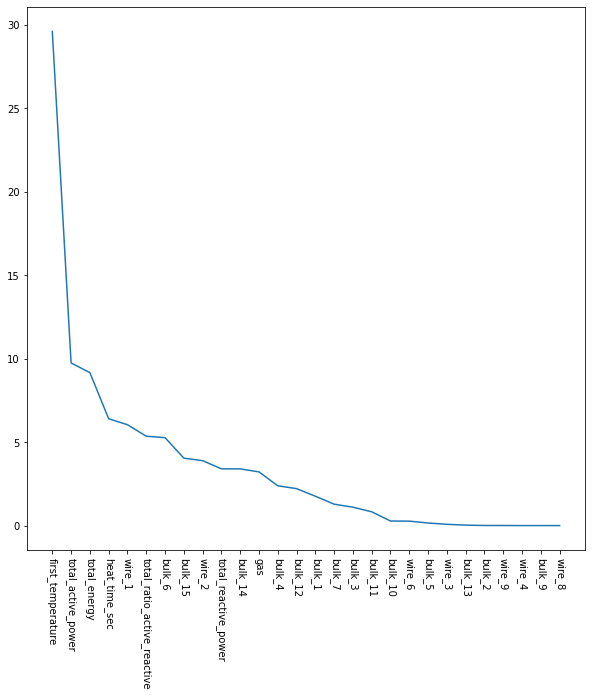

In [171]:
order = np.array(best_model.feature_importances_).argsort()[::-1]

plt.figure(figsize=(10, 10))
_ = plt.plot(
  np.array(best_model.feature_names_)[order],
  np.array(best_model.feature_importances_)[order])
_ = plt.xticks(rotation = -90)

Самый важный признак -- first_temperature. Второй по важности -- total_active_power. Что, если подумать, логично.

Text(0, 0.5, 'Last temperature')

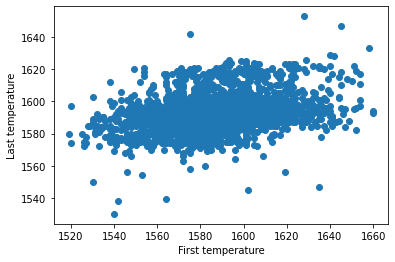

In [172]:
plt.plot(X['first_temperature'], y, 'o')
plt.xlabel('First temperature')
plt.ylabel('Last temperature')

Text(0, 0.5, 'Last temperature')

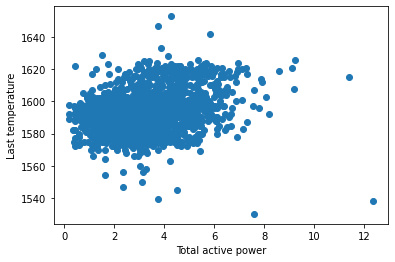

In [174]:
plt.plot(X['total_active_power'], y, 'o')
plt.xlabel('Total active power')
plt.ylabel('Last temperature')

Облака точек наклонены вверх, что свидетельствует о положительной корреляции между целевым значением и признаком

  ## Вывод

Целевая метрика на тестовой выборке достигнута. Лучий МАЕ показала модель CatBoost. Анализ лучшей модели показал, что на финальную температуру больше всего влияет начальная температура, активная мощность и общая энергия. Для того чтобы контролировать температуру, имеет смысл обратить внимание на эти параметры.

## Future work
В будущем выглядит логичным восстанавливать разность между начальной и конечной
температурами.